In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

from konlpy.tag import Mecab

import time
import re
import os
import io

print(pd.__version__)
print(tf.__version__)

1.3.3
2.6.0


In [2]:
# 한국어 말뭉치 사용을 위한 한국어를 지원하는 폰트로 변경

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

## 데이터 불러오기

In [3]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

## 데이터 정제 및 토큰화

In [4]:
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)
    
    # 원본 데이터 크기 확인
    print("RAW Korea Data Size:", len(kor))
    print("RAW English Data Size:", len(eng))
    
    # 한국어 문장과 영어 문장을 튜플로 묶기
    corpus = list(zip(kor, eng))

    # set을 사용하여 중복 제거
    unique_corpus = list(set(corpus))

    # 튜플을 풀어서 정제된 한국어와 영어 문장 얻기
    cleaned_kor, cleaned_eng = zip(*unique_corpus)

    cleaned_corpus = list(zip(cleaned_kor, cleaned_eng))
    
    # 중복 제거후 크기 사이즈 확인
    print("Cleaned Korea Data Size:", len(cleaned_kor))
    print("Cleaned English Data Size:", len(cleaned_eng))
    
    # 데이터 예시
    print("Example:")
    for sen_kor, sen_eng in zip(cleaned_kor[200:300][::20], cleaned_eng[200:300][::20]): 
        print(">>", sen_kor)
        print("   ", sen_eng)

    return cleaned_corpus

In [5]:
cleaned_corpus = clean_corpus(kor_path, eng_path)

RAW Korea Data Size: 94123
RAW English Data Size: 94123
Cleaned Korea Data Size: 78968
Cleaned English Data Size: 78968
Example:
>> 다우는 현재 250포인트, 그리고 나스닥은 23포인트 떨어졌습니다.
    the Dow currently down 250 points, NASDAQ off 23.
>> crackdown 단호한 단속[조치];
    More than 100 monks have marched in central Burma, the first time they have returned to the streets since last month´s bloody crackdown on protests.
>> 그는 텍사스 주의 사람들이 사형이 공정하고, 주의 시민들을 대상으로 저질러진 가장 끔찍한 죄에 합당한 처벌이라고 결정했음을 주장했다.
    He claimed Texans decided that the death penalty is a just and appropriate punishment for the most horrible crimes committed against the state´s citizens.
>> 가장 더운 기온을 기록했던 올해 날씨와 산타아나에서 부는 바람으로 이번주 산불 발생은 더욱 잦아졌다.
    Hot weather and Santa Ana winds marked the height of traditional wildfire season this weekend, after one of the driest years on record.
>> 그러나 그는 자신의 혈통에 대한 자부심이 워낙 커 다른 사람들이 주위에 있을 때는 공중 목욕탕에서도 결코 옷을 벗지 않는다.
    Yet he's so proud of his blood line that he never sheds his clothes in a public bath

preprocess_sentence 함수 만들기 

> 1. 모든 입력을 소문자로 변환합니다.  
> 2. 알파벳, 문장부호, 한글만 남기고 모두 제거합니다.  
> 3. 문장부호 양옆에 공백을 추가합니다.  
> 4. 문장 앞뒤의 불필요한 공백을 제거합니다.

In [6]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 소문자 변환, 양쪽 공백 제거
    
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence) # 문장 내의 구두점 앞뒤에 공백을 추가
    sentence = re.sub(r'[" "]+', " ", sentence) # 연속된 여러 개의 공백을 하나의 공백으로 축소
    sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z?.!,]+", " ", sentence) #  한글, 영문자와 구두점(. ? ! ,) 이외의 모든 문자를 공백으로 대체

    sentence = sentence.strip()
    
    return sentence #전처리된 문장을 반환  

In [7]:
cleaned_kor, cleaned_eng = zip(*cleaned_corpus)
# 100번째 문장 출력해서 확인
print("Korean:", cleaned_kor[100])
print(type(cleaned_kor))
print("English:", cleaned_eng[100])

Korean: 그는 또 “상당한 여행객들이 항공기 지연사태로 혼란을 겪을 것”이라고 덧붙였다.
<class 'tuple'>
English: "There will obviously be a number of passengers who will delayed as the airport plays catch-up.


In [8]:
kor_corpus = [] # 한국어
eng_corpus = [] # 영어

for pair in cleaned_corpus:
    kor, eng = pair[0], pair[1]
    kor_corpus.append(preprocess_sentence(kor))
    eng_corpus.append(preprocess_sentence(eng))
    
# 100번째 문장 출력해서 확인
print("Korean:", kor_corpus[100])
print("English:", eng_corpus[100])

Korean: 그는 또 상당한 여행객들이 항공기 지연사태로 혼란을 겪을 것 이라고 덧붙였다 .
English: there will obviously be a number of passengers who will delayed as the airport plays catch up .


sentencepiece를 이용하여 토큰화 진행하기
> * 단어 사전을 매개변수로 받아 원하는 크기의 사전을 정의할 수 있게 합니다. (기본: 20,000)  
> * 학습 후 저장된 model 파일을 SentencePieceProcessor() 클래스에 Load()한 후 반환합니다.
> *특수 토큰의 인덱스를 아래와 동일하게 지정합니다.
\<PAD> : 0 / \<BOS> : 1 / \<EOS> : 2 / \<UNK> : 3

In [9]:
# ! pip install sentencepiece

In [10]:
import sentencepiece as spm

# Sentencepiece를 활용하여 학습한 tokenizer를 생성
def generate_tokenizer(corpus,
                        vocab_size,
                        lang,
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    
    temp_file = os.getenv('HOME')+f'/aiffel/sp_tokenizer/data/korean-english-park.train.{lang}.temp'

    with open(temp_file, 'w') as f:
        for row in corpus:
            f.write(str(row) + '\n')

    model_name = f'{lang}_spm'
    spm.SentencePieceTrainer.Train(input = temp_file,
                                   model_prefix = model_name,
                                   vocab_size = vocab_size,
                                   pad_id = pad_id,
                                   bos_id = bos_id,
                                   eos_id = eos_id,
                                   unk_id = unk_id)
    
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(model_name+'.model')

    return tokenizer
    

SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

eng_corpus = []
kor_corpus = []

for pair in cleaned_corpus:
    k, e = pair[0], pair[1]

    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: ko_spm
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
}
normalizer_spec {
  name: nmt_nfkc
  add_dumm

True


trainer_interface.cc(626) LOG(INFO) Saving vocabs: en_spm.vocab


토크나이저를 활용해 토큰의 길이가 50 이하인 데이터를 선별하여 src_corpus 와 tgt_corpus 를 각각 구축하고, 텐서 enc_train 과 dec_train 으로 변환

In [11]:
from tqdm.notebook import tqdm    # Process 과정을 보기 위해
src_corpus = []
tgt_corpus = []
text_max_len = 50

assert len(kor_corpus) == len(eng_corpus)

for idx in tqdm(range(len(kor_corpus))):
    ko_tokenized = ko_tokenizer.EncodeAsIds(kor_corpus[idx])
    en_tokenized = en_tokenizer.EncodeAsIds(eng_corpus[idx])
    
    if len(ko_tokenized) <= text_max_len and len(en_tokenized) <= text_max_len:
        src_corpus.append(ko_tokenized)
        tgt_corpus.append(en_tokenized)

enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

  0%|          | 0/78968 [00:00<?, ?it/s]

In [12]:
print("Korean Encoded")
print(enc_train[10], "\n")
print("Korean Decoded")
print(ko_tokenizer.DecodeIds(enc_train[10].tolist()), "\n\n")
print("English Encoded")
print(dec_train[10], "\n")
print("English Decoded")
print(en_tokenizer.DecodeIds(dec_train[10].tolist()), "\n")

Korean Encoded
[  138  1755  1108    34  1365 10471     8    50     7  8169  5029   328
  4059  3352     5  6906   207  8169   285  6451   238   255   144   114
 17036  1535     6   478     5  2173    24     4     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0] 

Korean Decoded
현재 사원 안에 있는 학생 반군들은 정부의 항복 권고에도 불구 저항을 계속하고 있으며 항복하느니 차라리 순교하겠다는 입장을 보이고 있다 . 


English Encoded
[   1    4 1029 1864  310   46    9   70  600   11    4 1620   15 1226
    6  819  554   38 2051  417 1862 2008   99    6   72 1171  276  402
    6   27 1275   21   12 2295    5    2    0    0    0    0    0    0
    0    0    0    0    0    0    0    0] 

English Decoded
the standoff came after a government investigation of the mosque s activities , whose students are demanding taliban style sharia , or islamic law , be instituted in islamabad . 



## 모델 설계

In [13]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table


In [14]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        '''
        Scaled QK 값 구하기
        '''
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  
        '''
        1. Attention Weights 값 구하기 -> attentions
        2. Attention 값을 V에 곱하기 -> out
        '''
        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        """
        Embedding을 Head의 수로 분할하는 함수

        x: [ batch x length x emb ]
        return: [ batch x heads x length x self.depth ]
        """
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        """
        분할된 Embedding을 하나로 결합하는 함수

        x: [ batch x heads x length x self.depth ]
        return: [ batch x length x emb ]
        """
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
    				        
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

In [15]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff): # d_ff: 2048 # d_model: 512 
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu') # 2048
        self.w_2 = tf.keras.layers.Dense(d_model) # 512

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

In [16]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

In [17]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [18]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [19]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [20]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [21]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src) #  Attention을 할 때에 <PAD> 토큰에도 Attention을 주는 것을 방지해 주는 역할
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

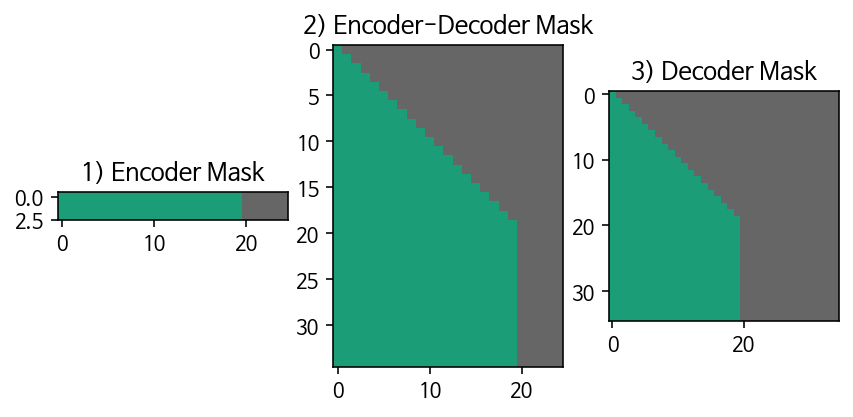

In [22]:
batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

### LearningRateScheduler

In [23]:
# LearningRateScheduler 구현
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

### Loss Function

In [24]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

### Train Step

In [25]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

### Evaluation

In [26]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [27]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [28]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

## 모델 학습

In [30]:
transformer = Transformer(n_layers=2, 
                          d_model=512, 
                          n_heads=8, 
                          d_ff=2048, 
                          src_vocab_size=SRC_VOCAB_SIZE, 
                          tgt_vocab_size=TGT_VOCAB_SIZE, 
                          pos_len=256, 
                          dropout=0.1)

In [31]:
learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

In [32]:
from tqdm import tqdm_notebook 
import random

BATCH_SIZE = 64
EPOCHS = 20

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

/tmp/ipykernel_1499/99984386.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a big .
Input: 시민들은 도시 속에 산다.
Predicted translation: the town of the sameth .
Input: 커피는 필요 없다.
Predicted translation: it s not be a lot of the cause .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was killed .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a big vote .
Input: 시민들은 도시 속에 산다.
Predicted translation: people are living in the city .
Input: 커피는 필요 없다.
Predicted translation: it s not a  ⁇ 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll from the death toll of .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a political trick .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is located in the city .
Input: 커피는 필요 없다.
Predicted translation: coffee doesn t need anything right .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll killed people .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the president is the first of the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is the first of the city .
Input: 커피는 필요 없다.
Predicted translation: it is not known to have a need .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on saturday , the death toll was .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the first president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they re just one of the city .
Input: 커피는 필요 없다.
Predicted translation: there s no need for any wrongdoing .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: saturday struck the lowest level of seven deaths .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a former president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they re just a safe town .
Input: 커피는 필요 없다.
Predicted translation: coffee need is a no stranger for any wrongdoing .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll from saturday struck .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a presidential candidate for president .
Input: 시민들은 도시 속에 산다.
Predicted translation: there are only one city to see cities .
Input: 커피는 필요 없다.
Predicted translation: it s necessary to take a full of the consumer goods , he needs .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths were reported wednesday .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a pror .
Input: 시민들은 도시 속에 산다.
Predicted translation: there is a urban sentiment in the city of brooks .
Input: 커피는 필요 없다.
Predicted translation: it s necessary to take a look at the end .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was not confirmed monday .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a presidential candidate .
Input: 시민들은 도시 속에 산다.
Predicted translation: true town is true .
Input: 커피는 필요 없다.
Predicted translation: it doesn t need any chocolate or talks need .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died saturday .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a son . percent .
Input: 시민들은 도시 속에 산다.
Predicted translation: they re growing in the city for a nd minute .
Input: 커피는 필요 없다.
Predicted translation: it doesn t need any eu sales .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on saturday , a magnitude . earthquake hit the saturdayside .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a presidential candidate .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens havekept in the city .
Input: 커피는 필요 없다.
Predicted translation: it has nothing to do with it .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed monday on saturday .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a spokesman for the presidential office .
Input: 시민들은 도시 속에 산다.
Predicted translation: there s for example .
Input: 커피는 필요 없다.
Predicted translation: it s necessary to stop at the coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed monday and seven were wounded monday by the official government added .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is being linked to his rival .
Input: 시민들은 도시 속에 산다.
Predicted translation: townsfolk is sometimes terms .
Input: 커피는 필요 없다.
Predicted translation: if it needs to get a vote .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed monday in the seven taylor s death on monday , leaving the death toll from the saturday .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama is friendly with his wife .
Input: 시민들은 도시 속에 산다.
Predicted translation: everybody is feel true .
Input: 커피는 필요 없다.
Predicted translation: the coffee is needed to take away with its white house needs to need for its future .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on saturday , seven magnitude was seven from the deaths of seven people .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a spokesman .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens portrays them as for cover .
Input: 커피는 필요 없다.
Predicted translation: it s necessary to do when referred to sales .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on saturday , seven magnitude earthquakes hit the seven toll .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the second presidential candidate .
Input: 시민들은 도시 속에 산다.
Predicted translation: there were feels the city for dinner .
Input: 커피는 필요 없다.
Predicted translation: if it s necessary to stop at coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on saturday , seven people were killed and were saturday in the iraqi city s seven year history , which killed was saturday and died on saturday , officials said .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the son of president bush .
Input: 시민들은 도시 속에 산다.
Predicted translation: they re all part of the city .
Input: 커피는 필요 없다.
Predicted translation: it s necessary to do when it goes too .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven magnitude restaurants in iraq killed monday .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the country s president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they re city sold to the city .
Input: 커피는 필요 없다.
Predicted translation: it s necessary to need coffee needs .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on saturday seven people were killed when seven magnitude .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: it is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: citys have led to the city .
Input: 커피는 필요 없다.
Predicted translation: if its effort needs to get at its .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on saturday seven people were killed , officials said .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the spokesman .
Input: 시민들은 도시 속에 산다.
Predicted translation: they re looking for a towns .
Input: 커피는 필요 없다.
Predicted translation: if don t need coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: wednesday killed people and died on monday , officials said .


Input: 오바마는 대통령이다.
Predicted translation: obama is the spokesman .
Encoder Layer 1


/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


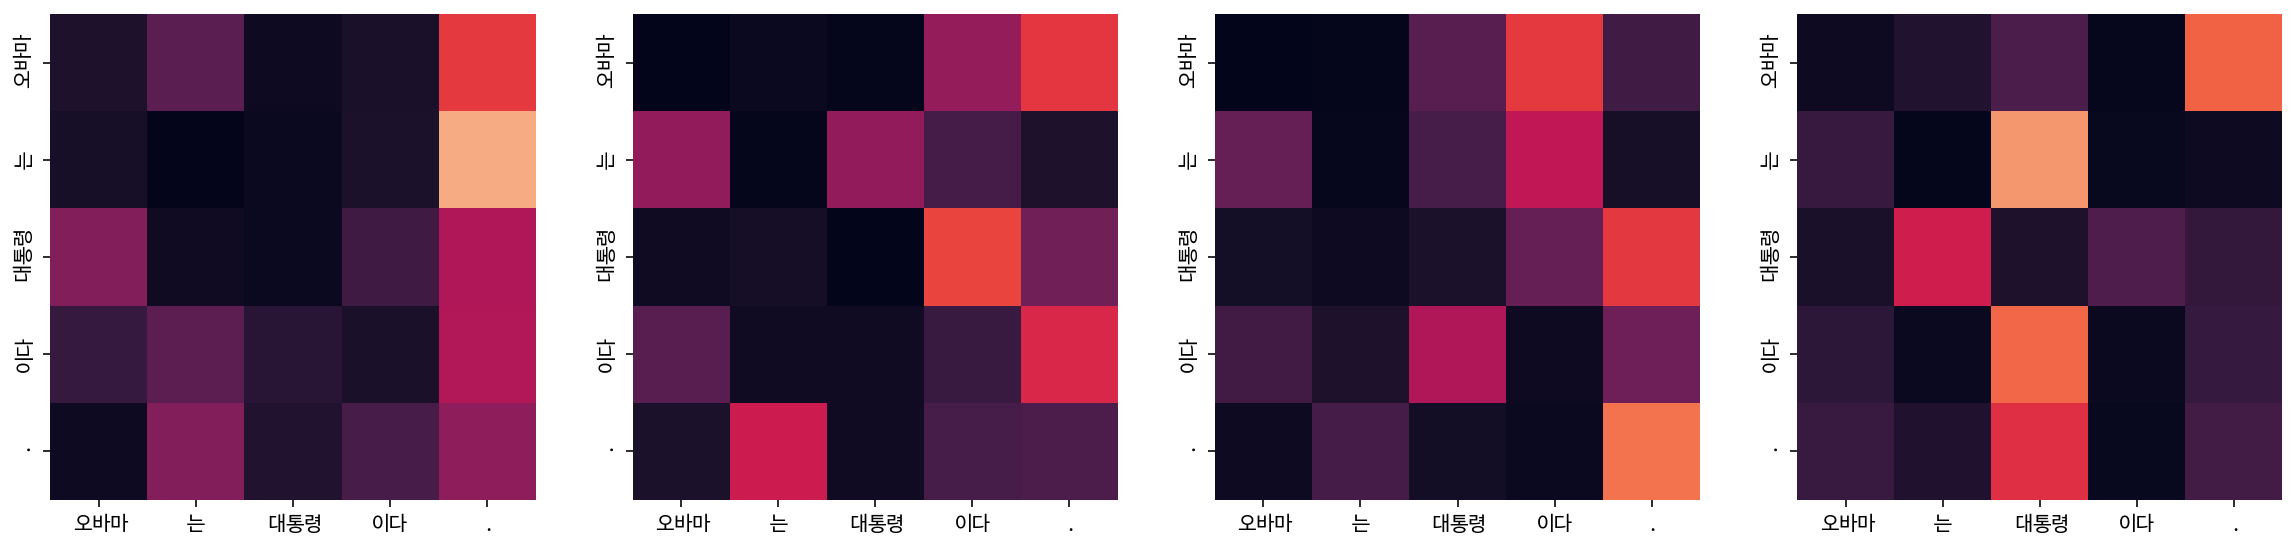

Encoder Layer 2


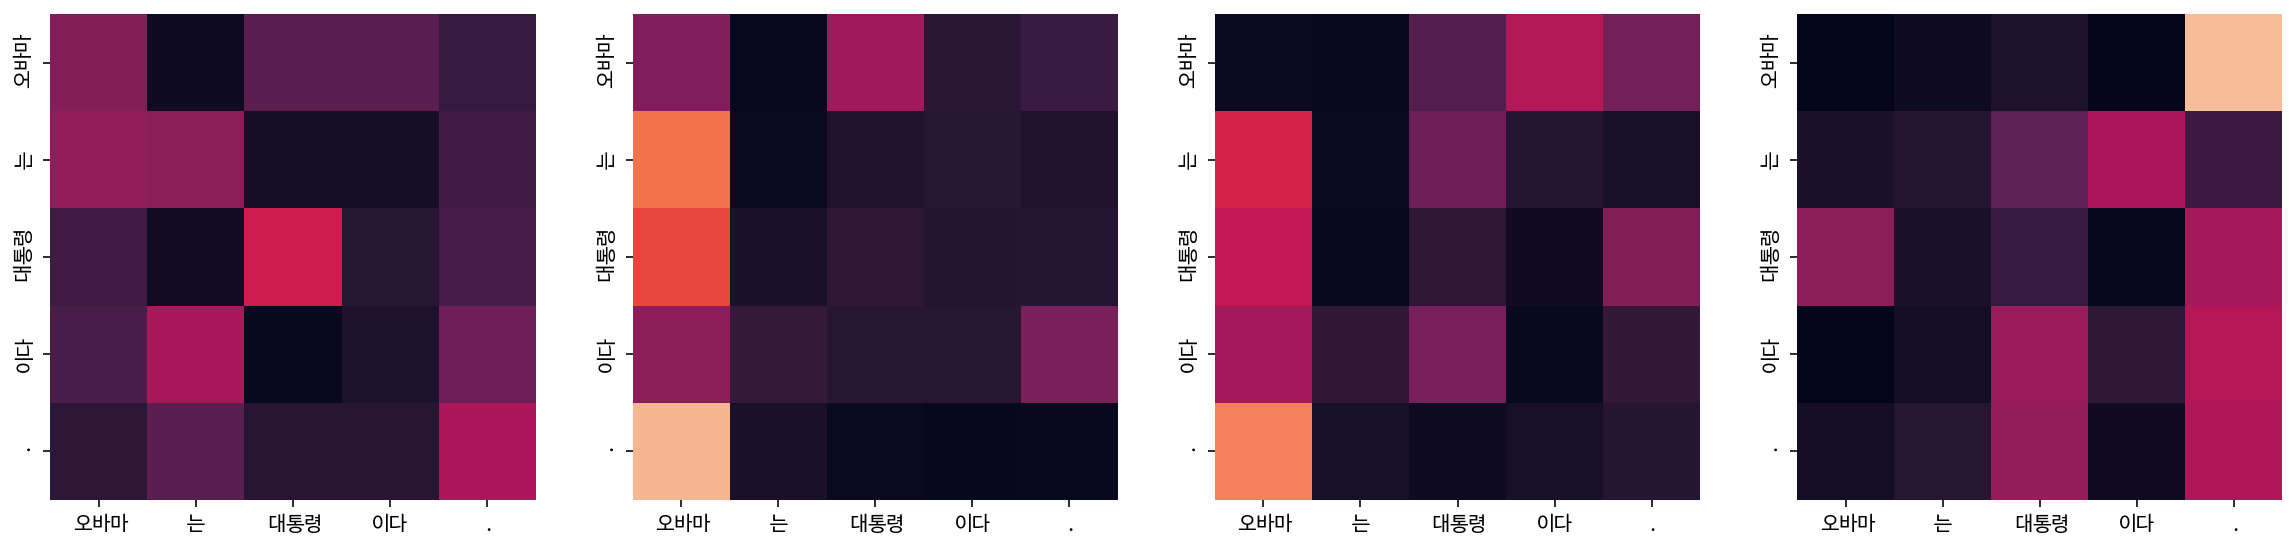

Decoder Self Layer 1


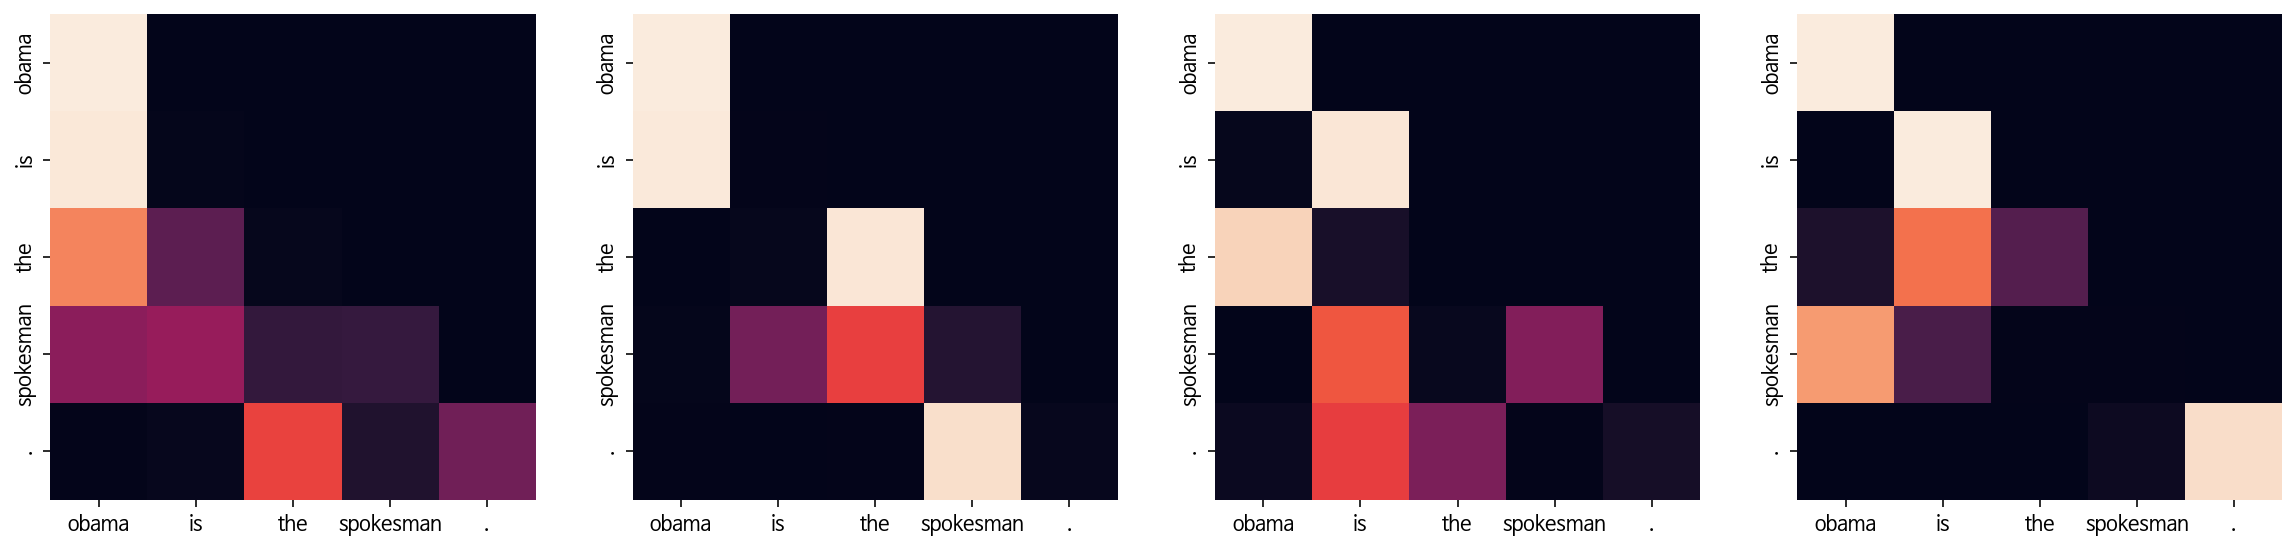

Decoder Src Layer 1


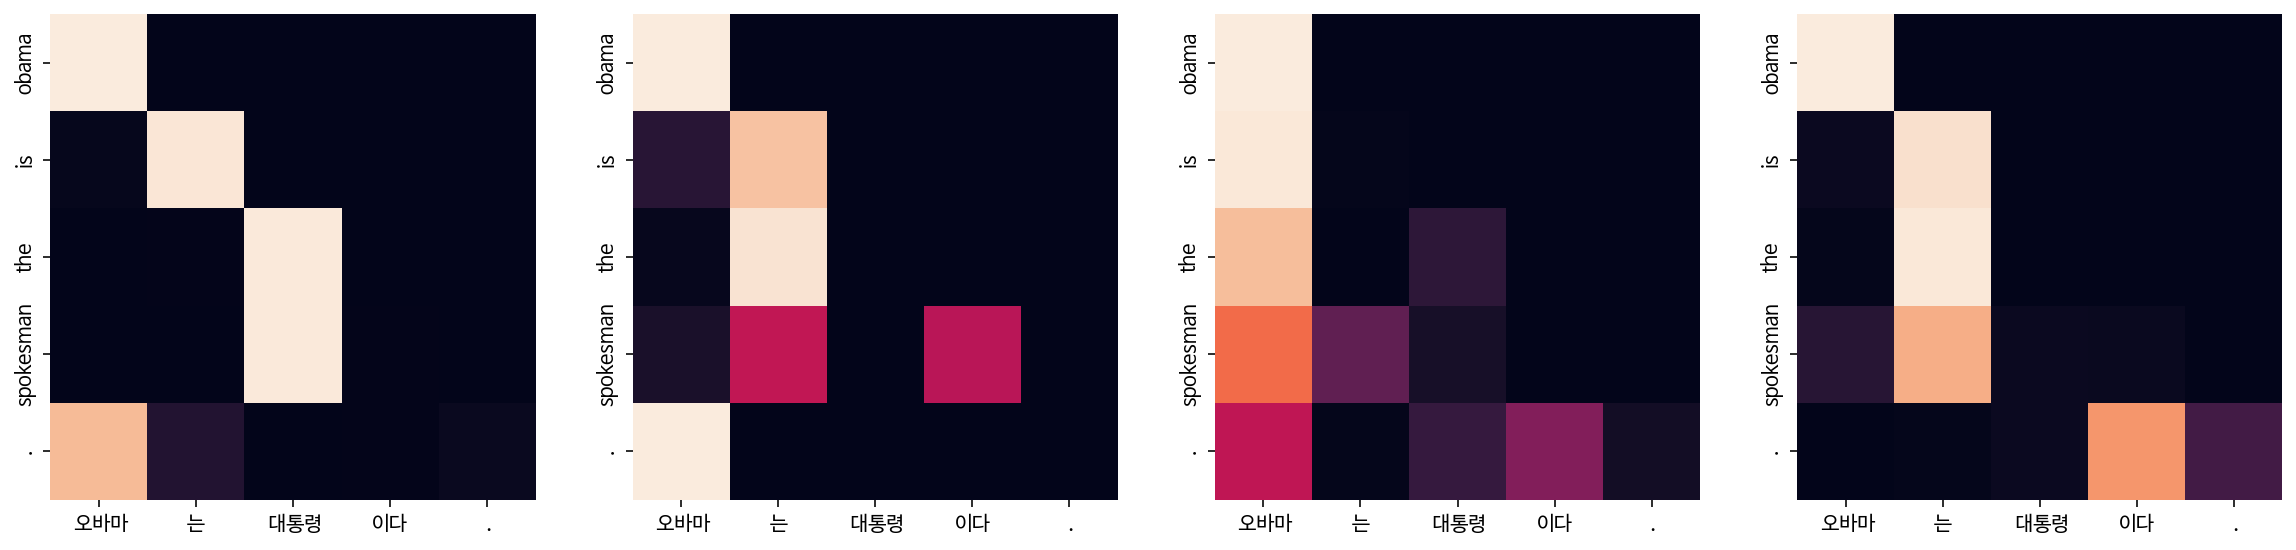

Decoder Self Layer 2


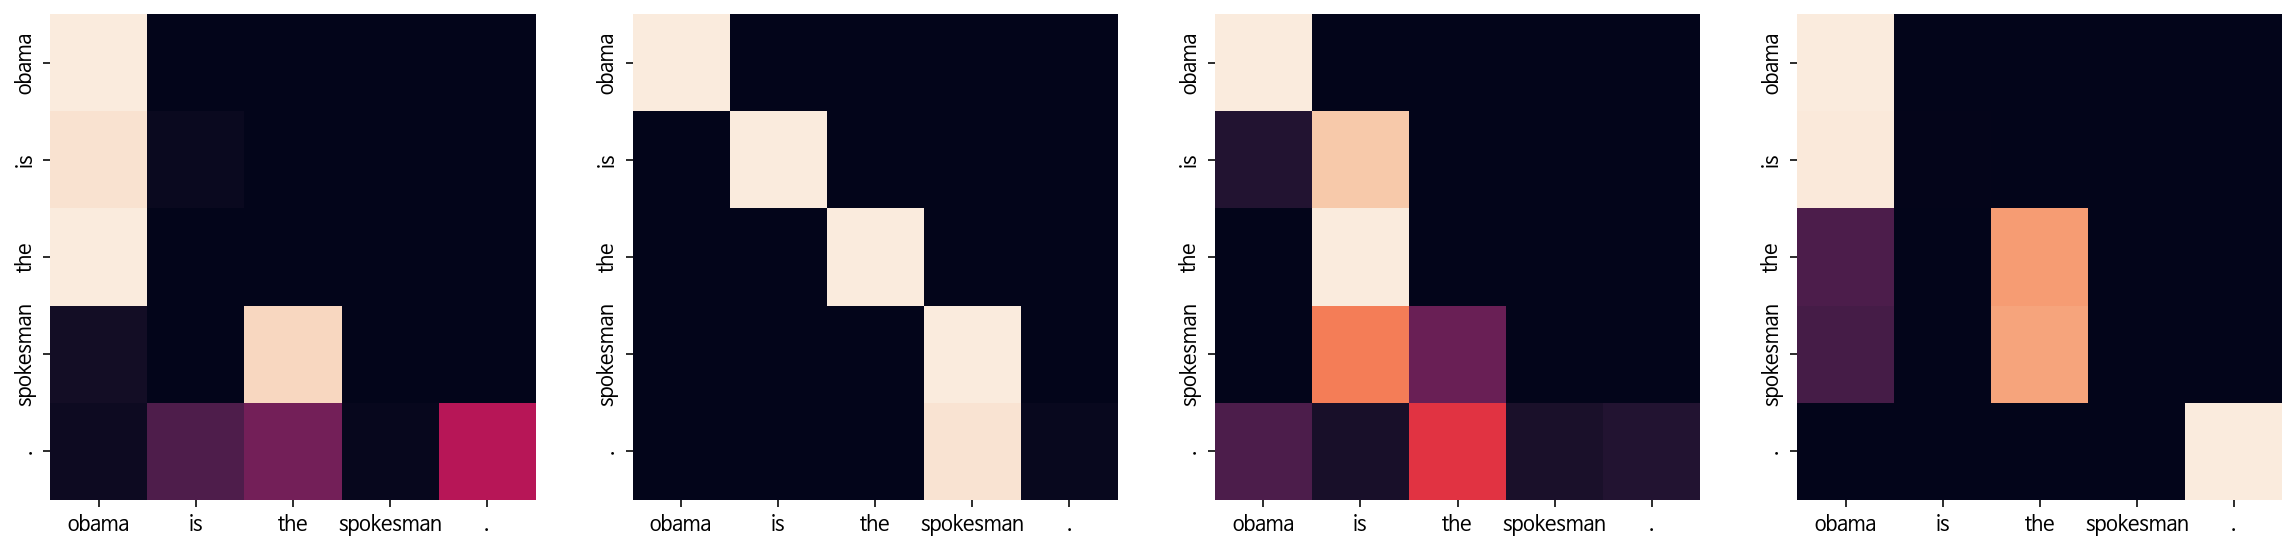

Decoder Src Layer 2


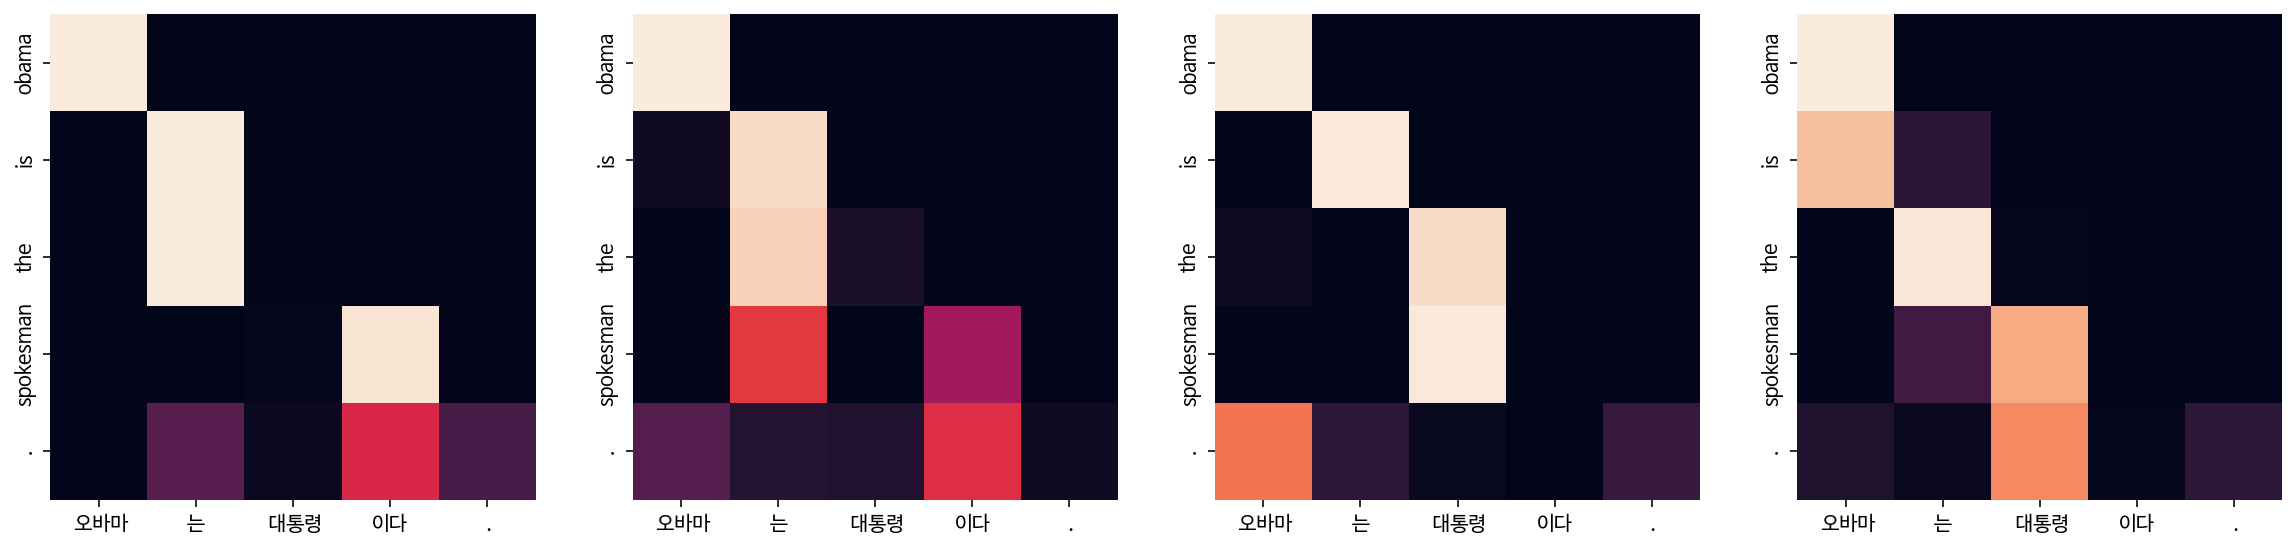

Input: 시민들은 도시 속에 산다.
Predicted translation: they re looking for a towns .
Encoder Layer 1


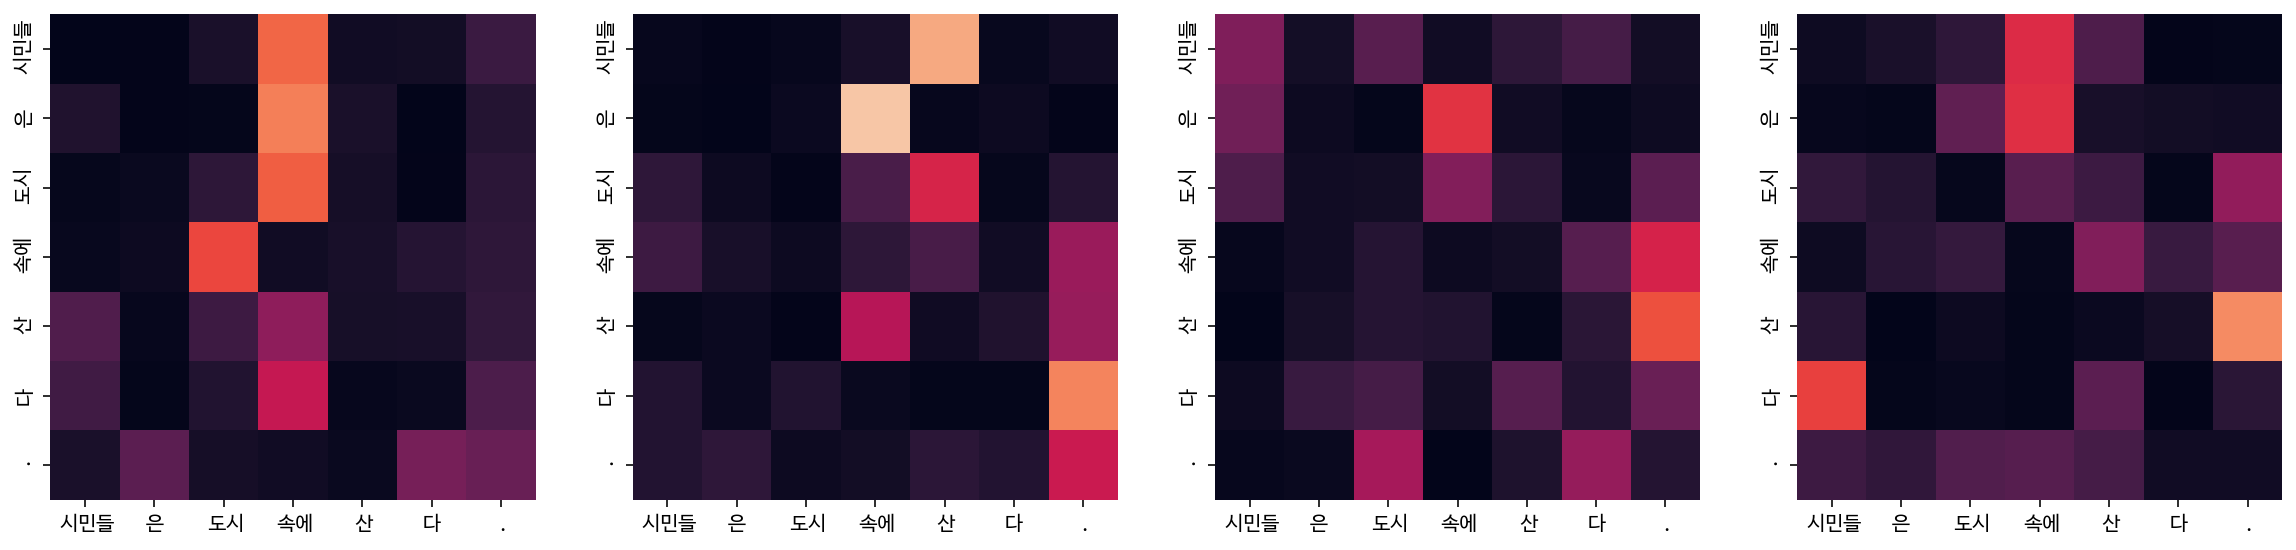

Encoder Layer 2


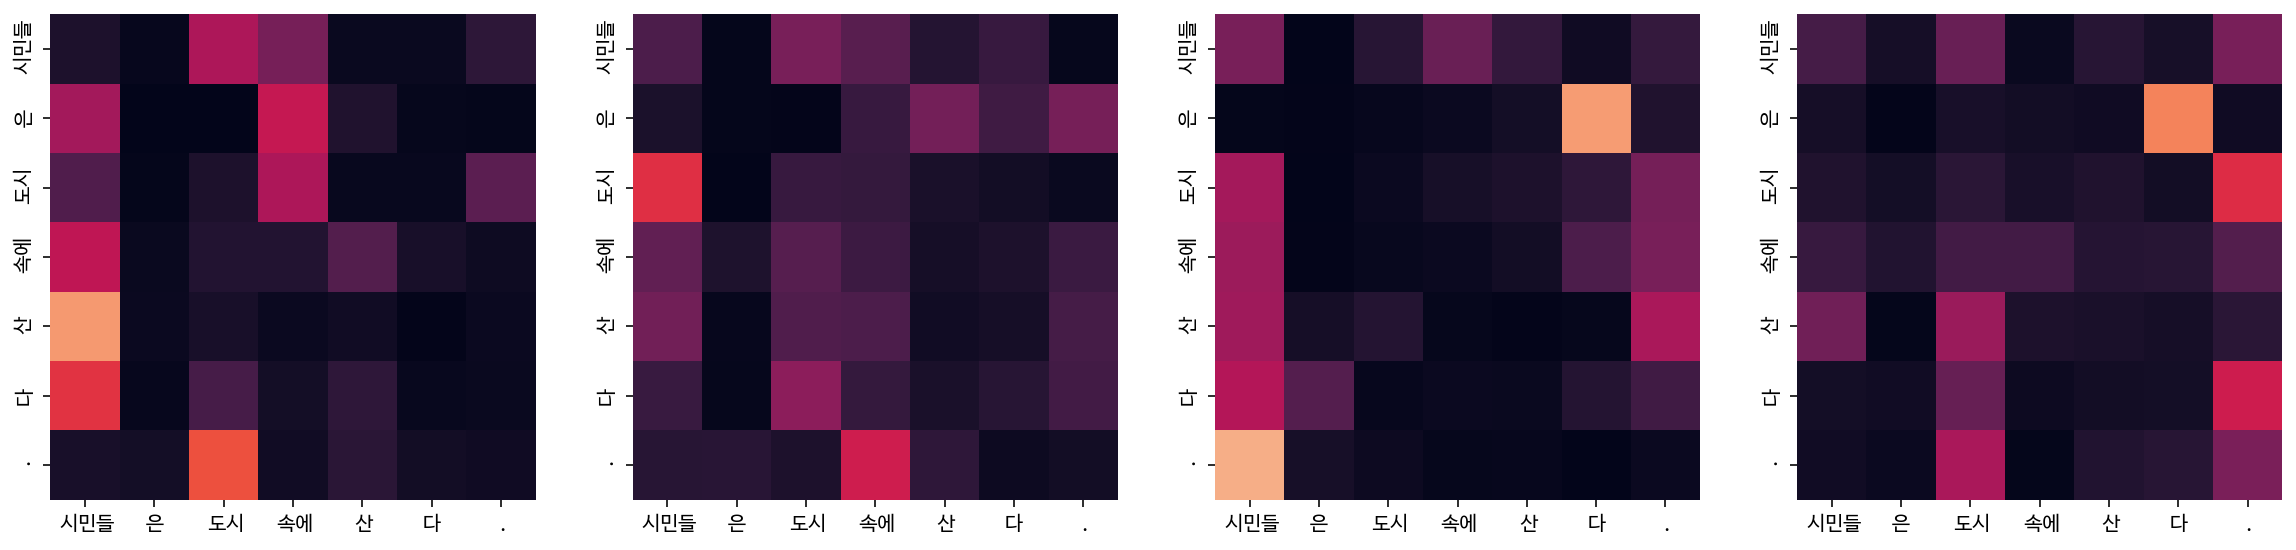

Decoder Self Layer 1


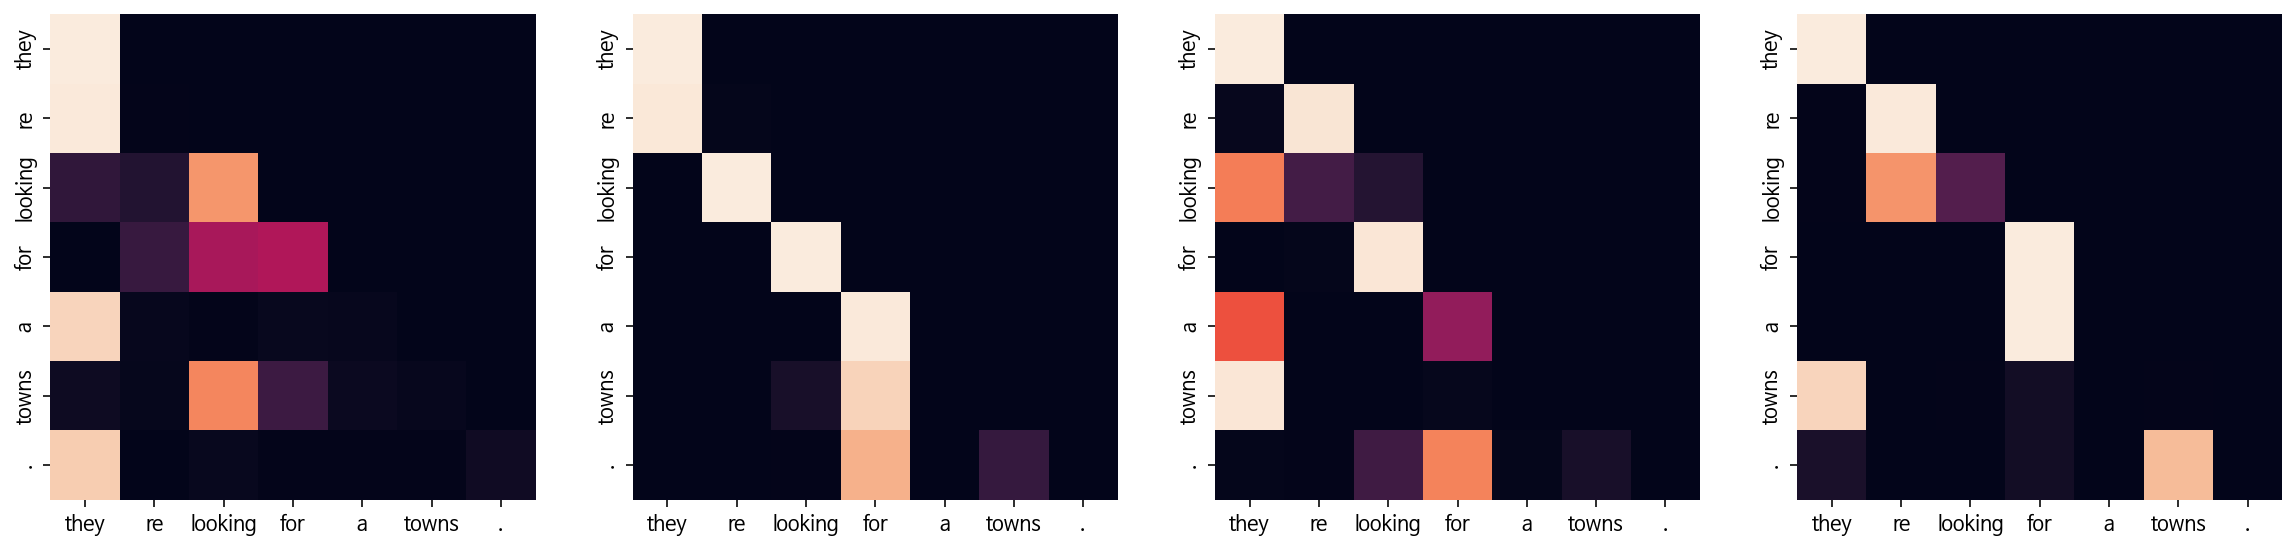

Decoder Src Layer 1


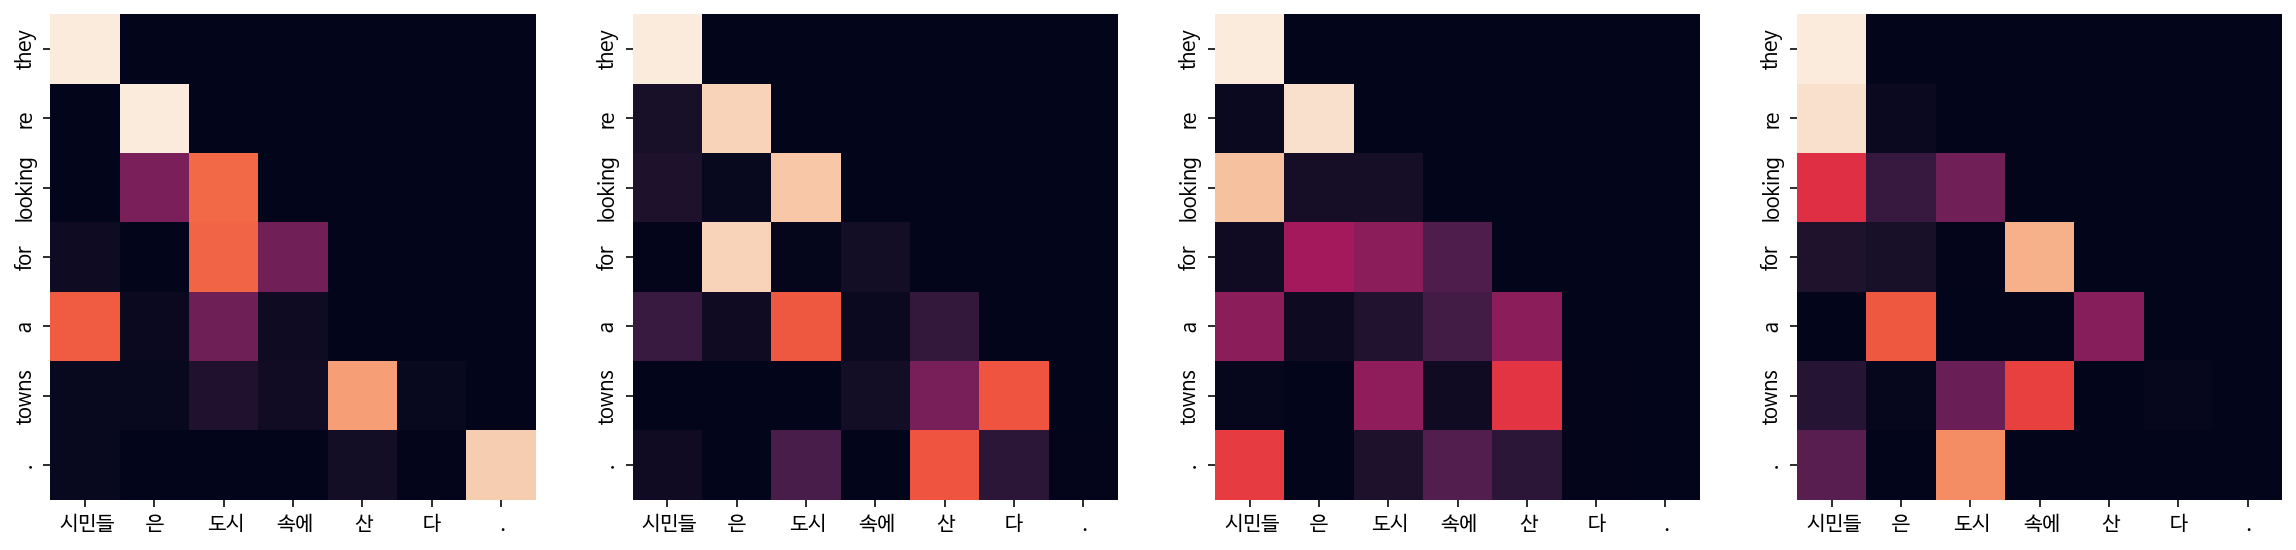

Decoder Self Layer 2


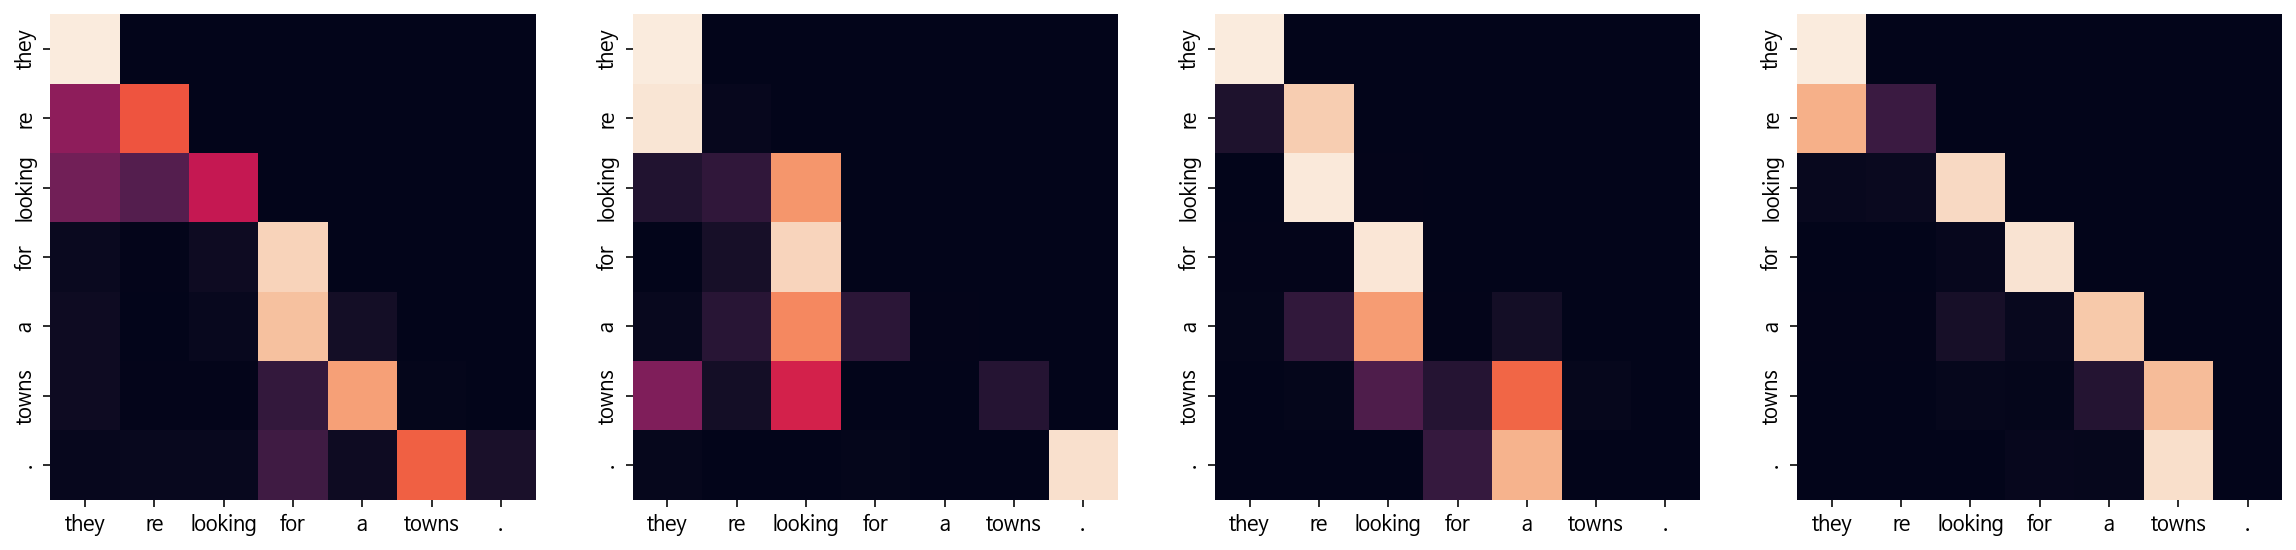

Decoder Src Layer 2


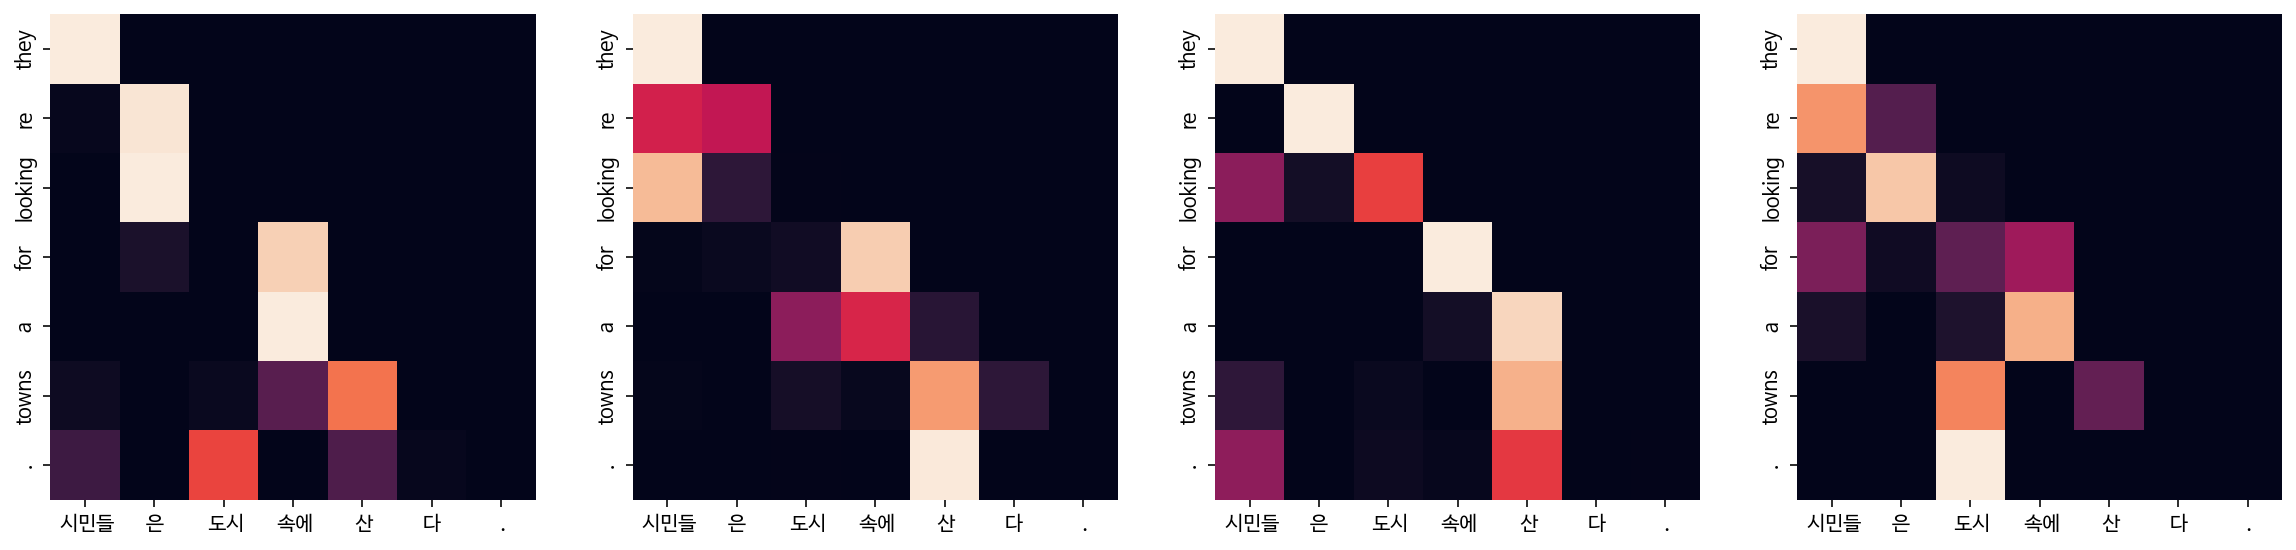

Input: 커피는 필요 없다.
Predicted translation: if don t need coffee .
Encoder Layer 1


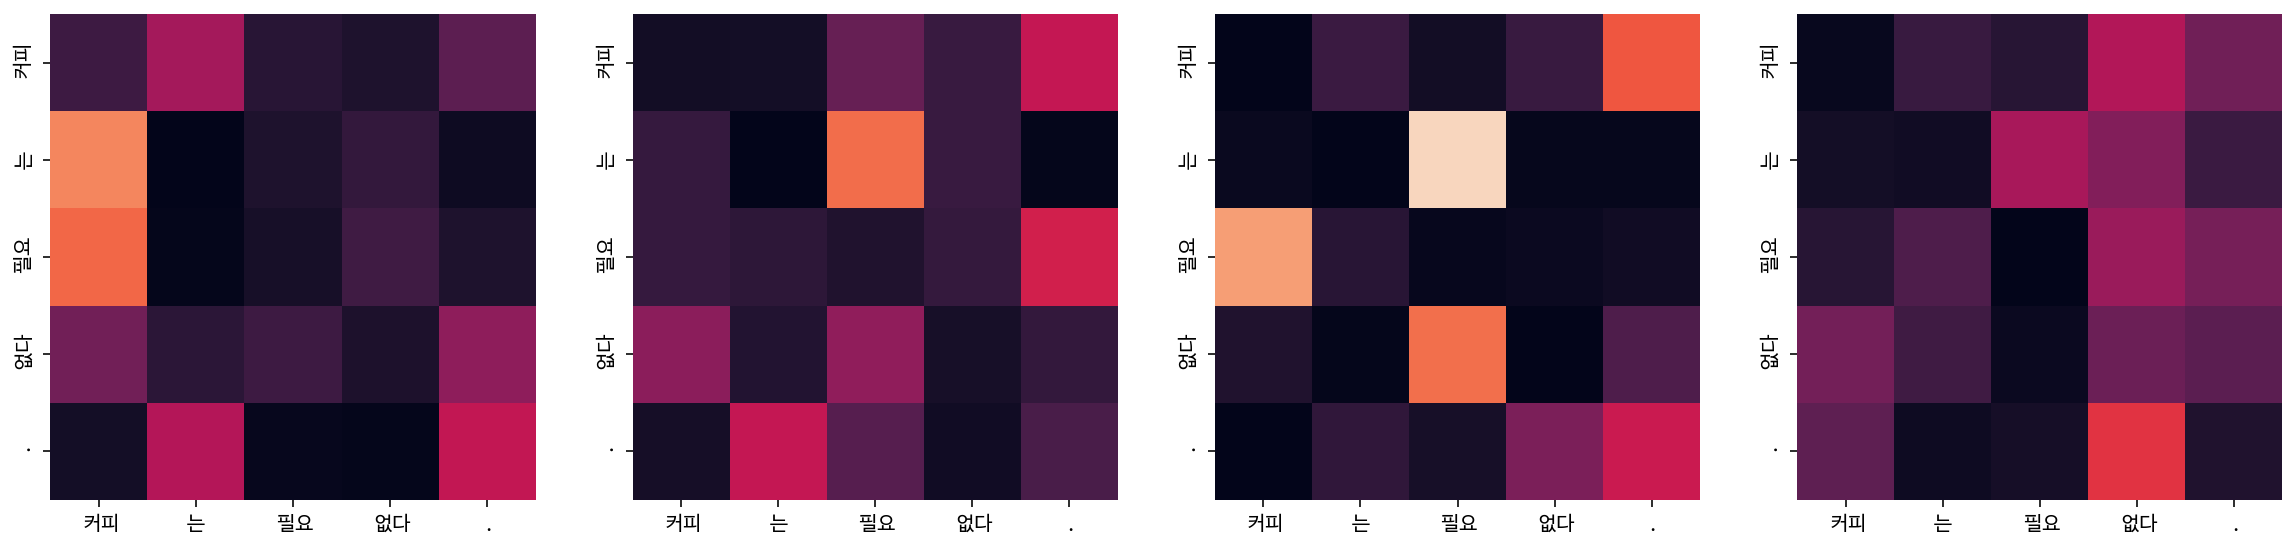

Encoder Layer 2


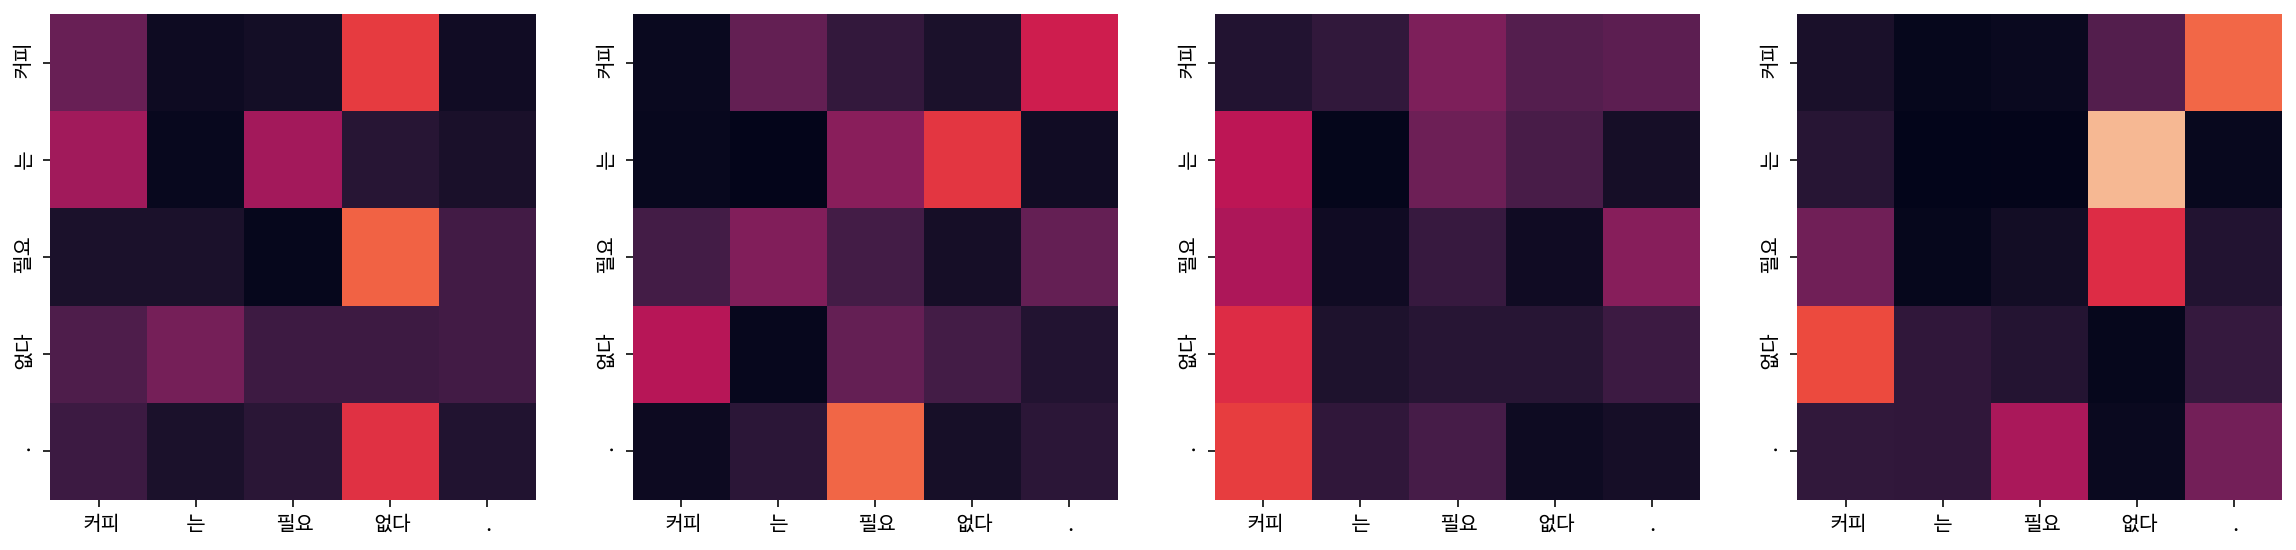

Decoder Self Layer 1


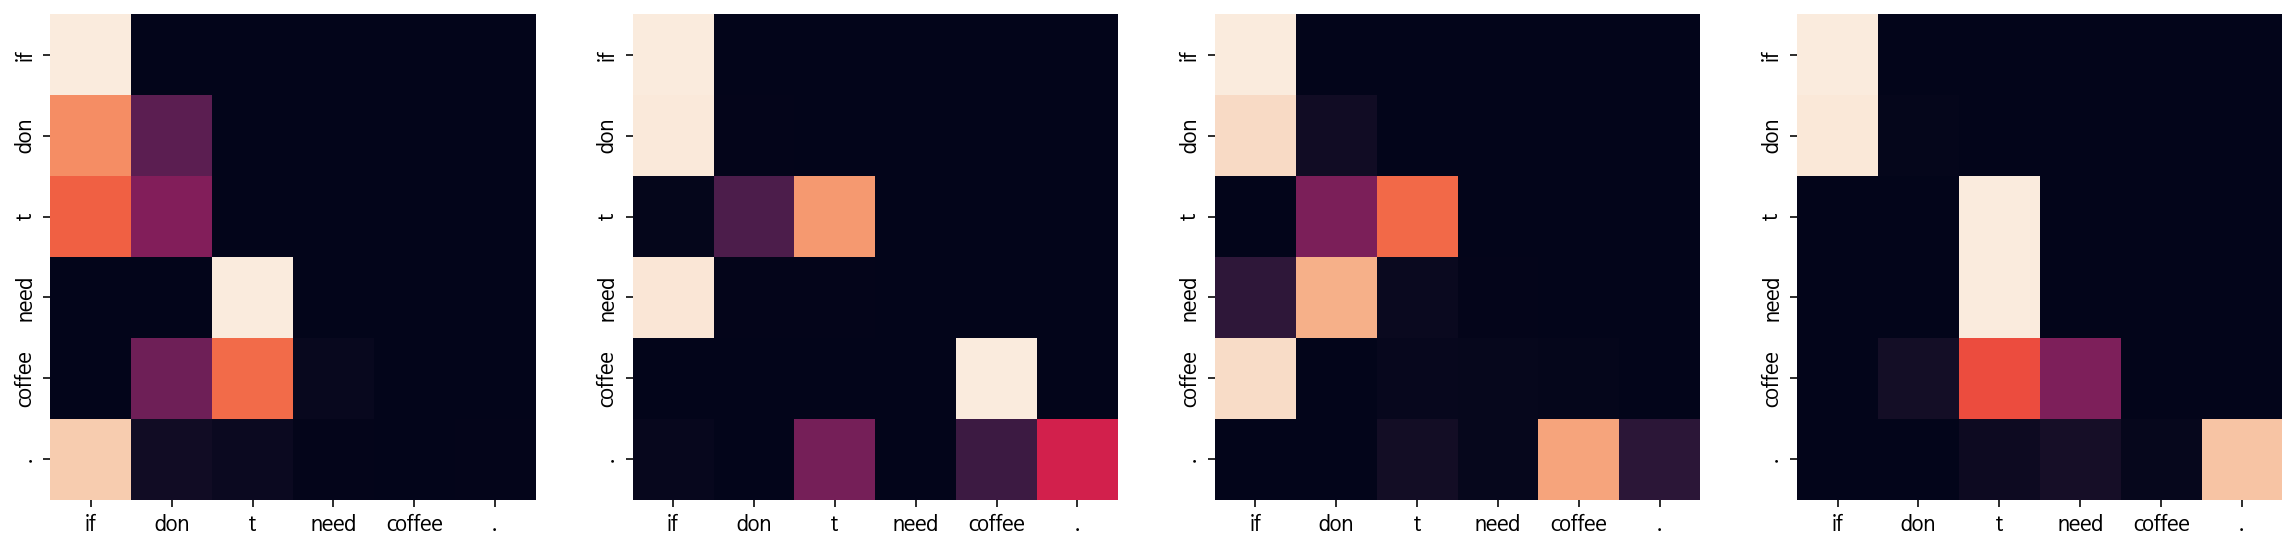

Decoder Src Layer 1


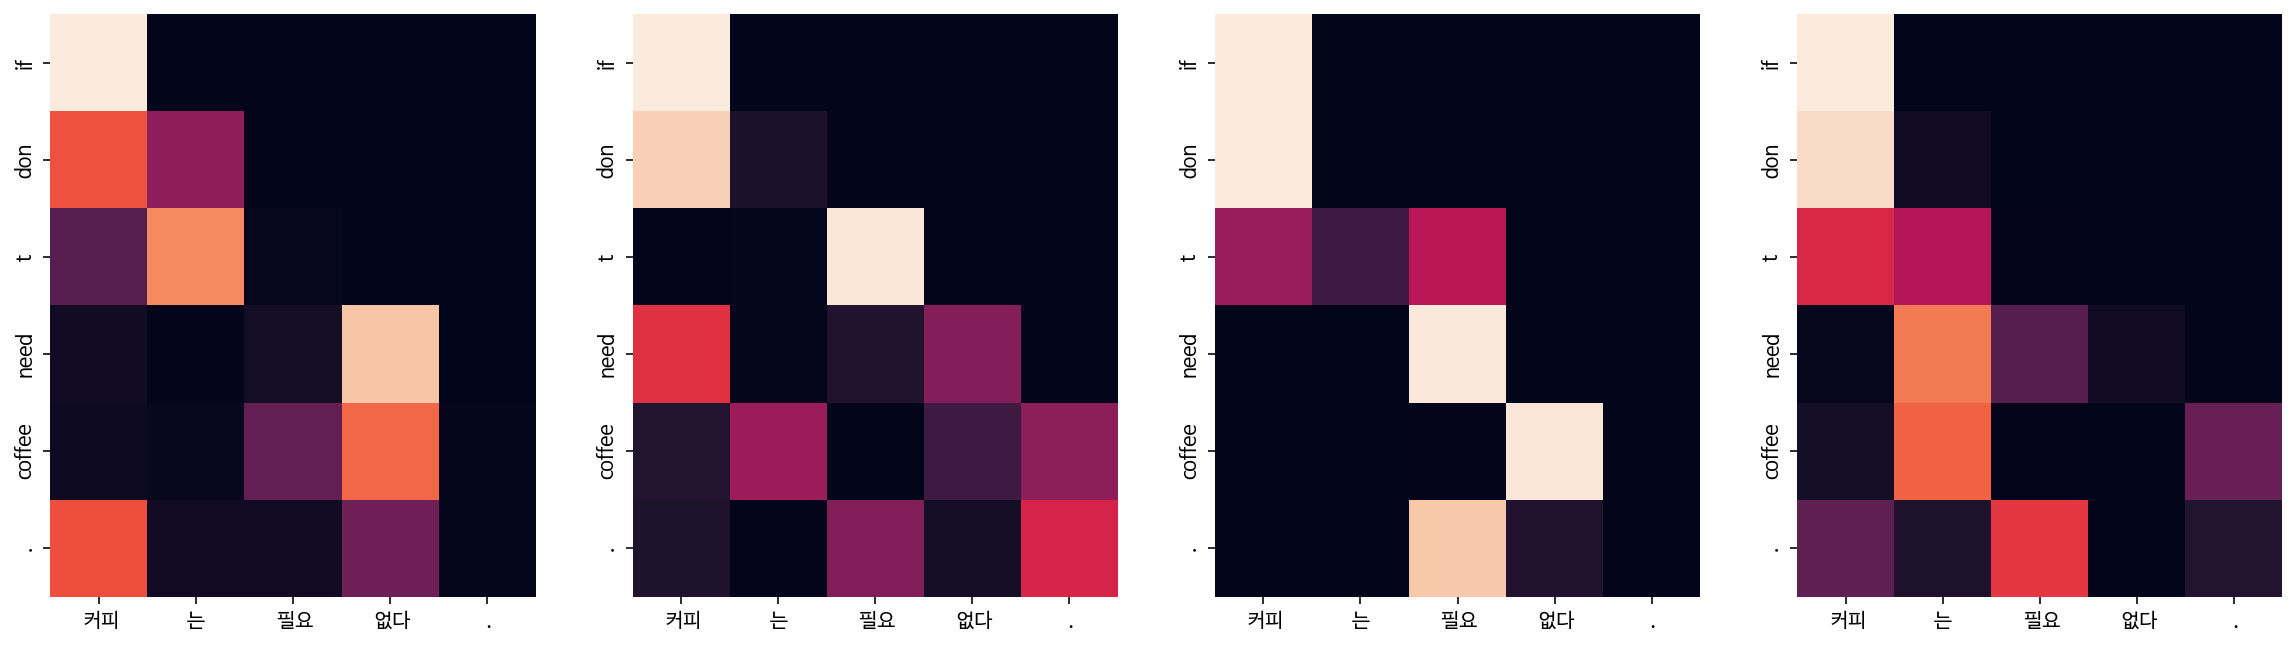

Decoder Self Layer 2


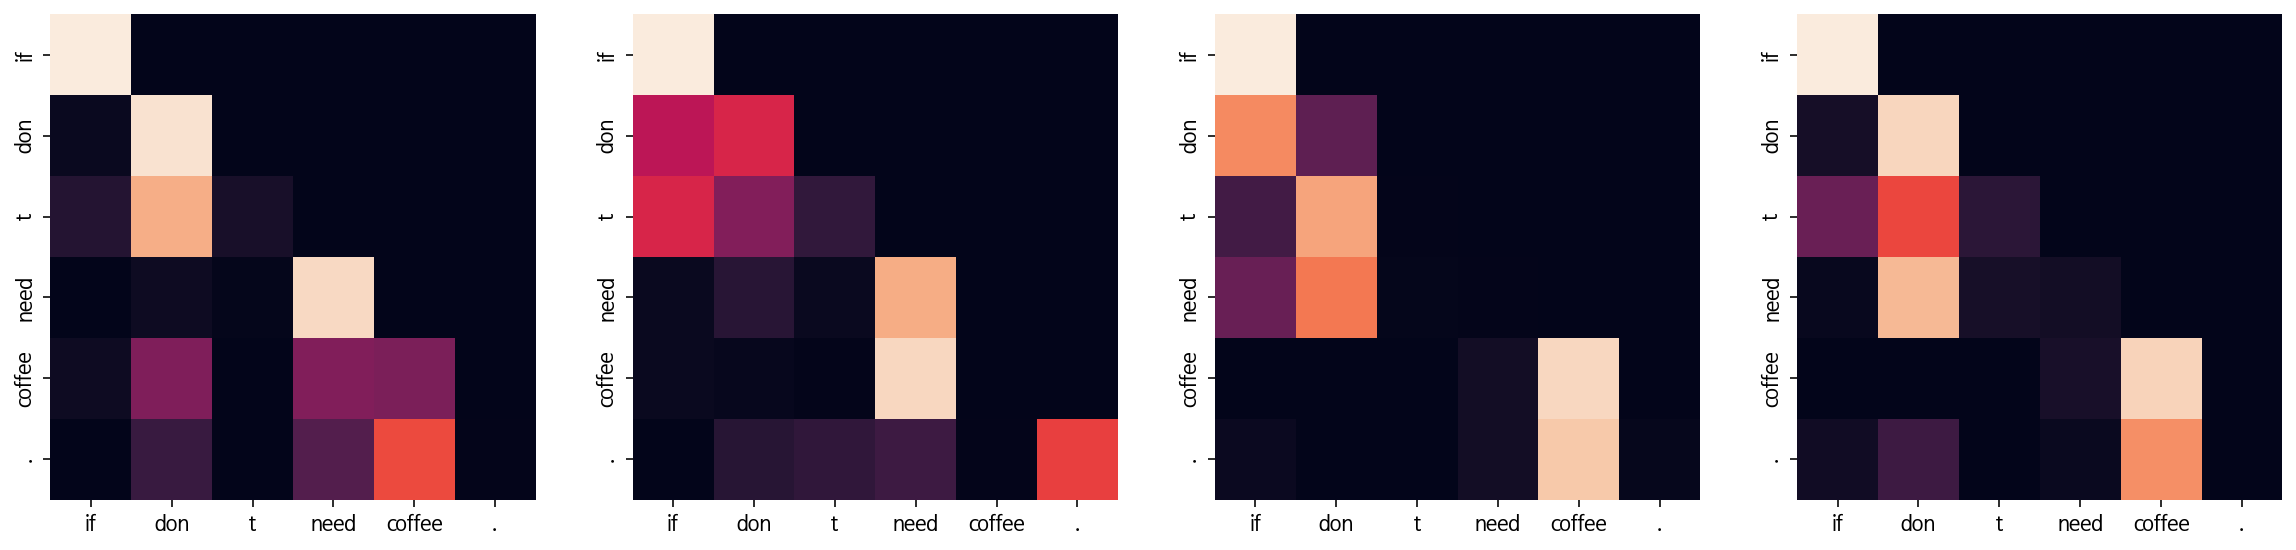

Decoder Src Layer 2


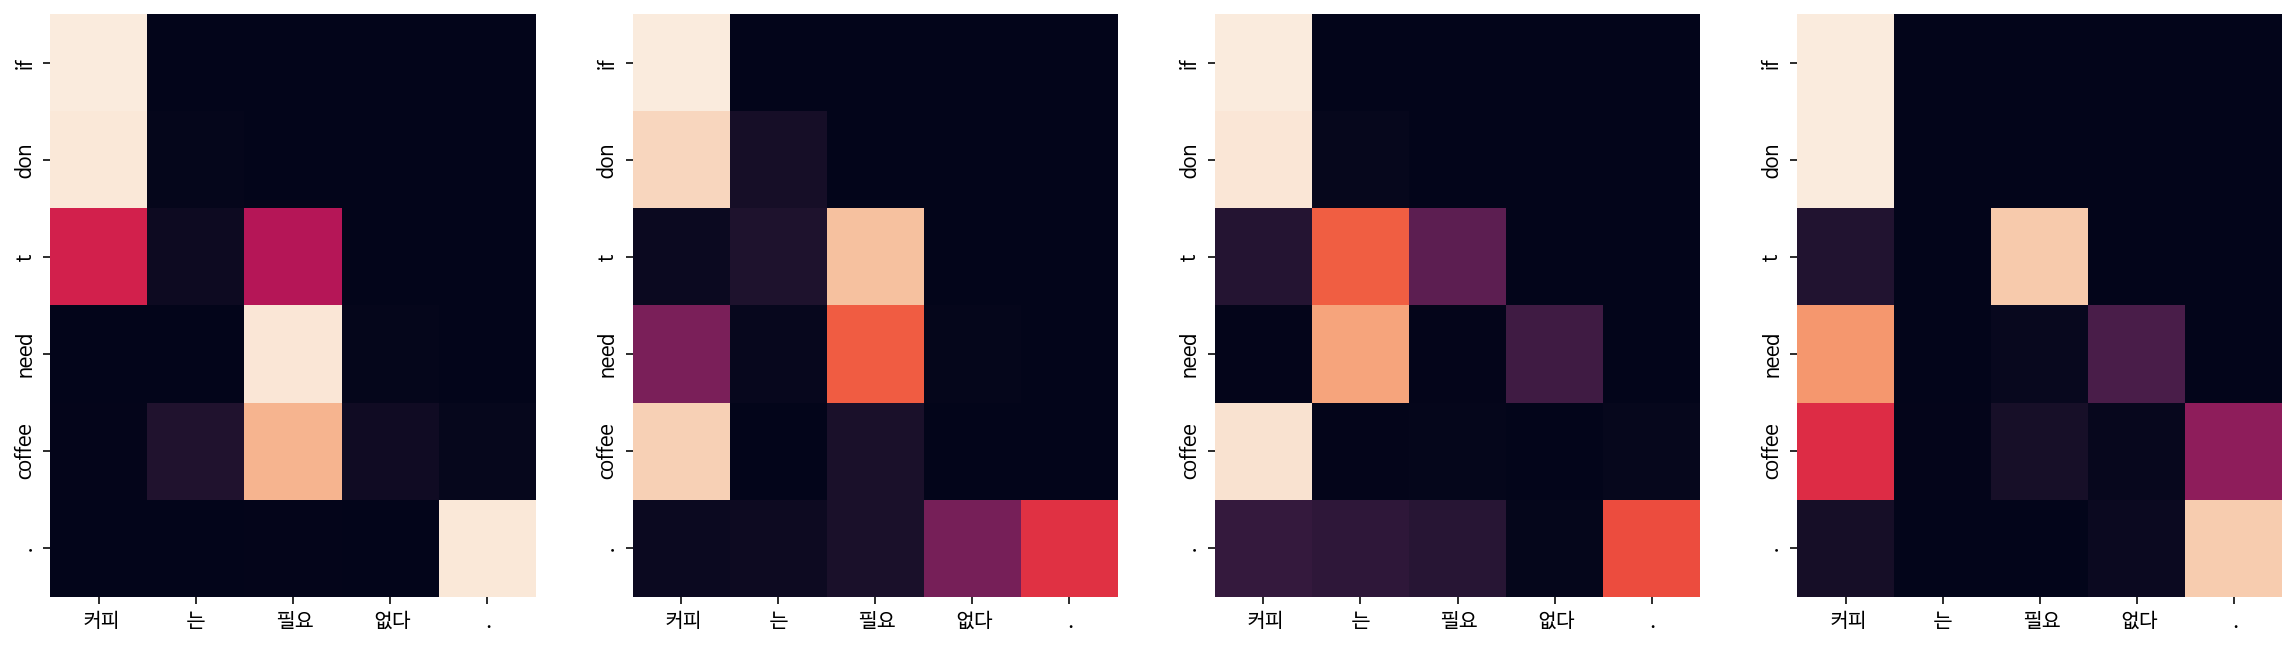

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: wednesday killed people and died on monday , officials said .
Encoder Layer 1


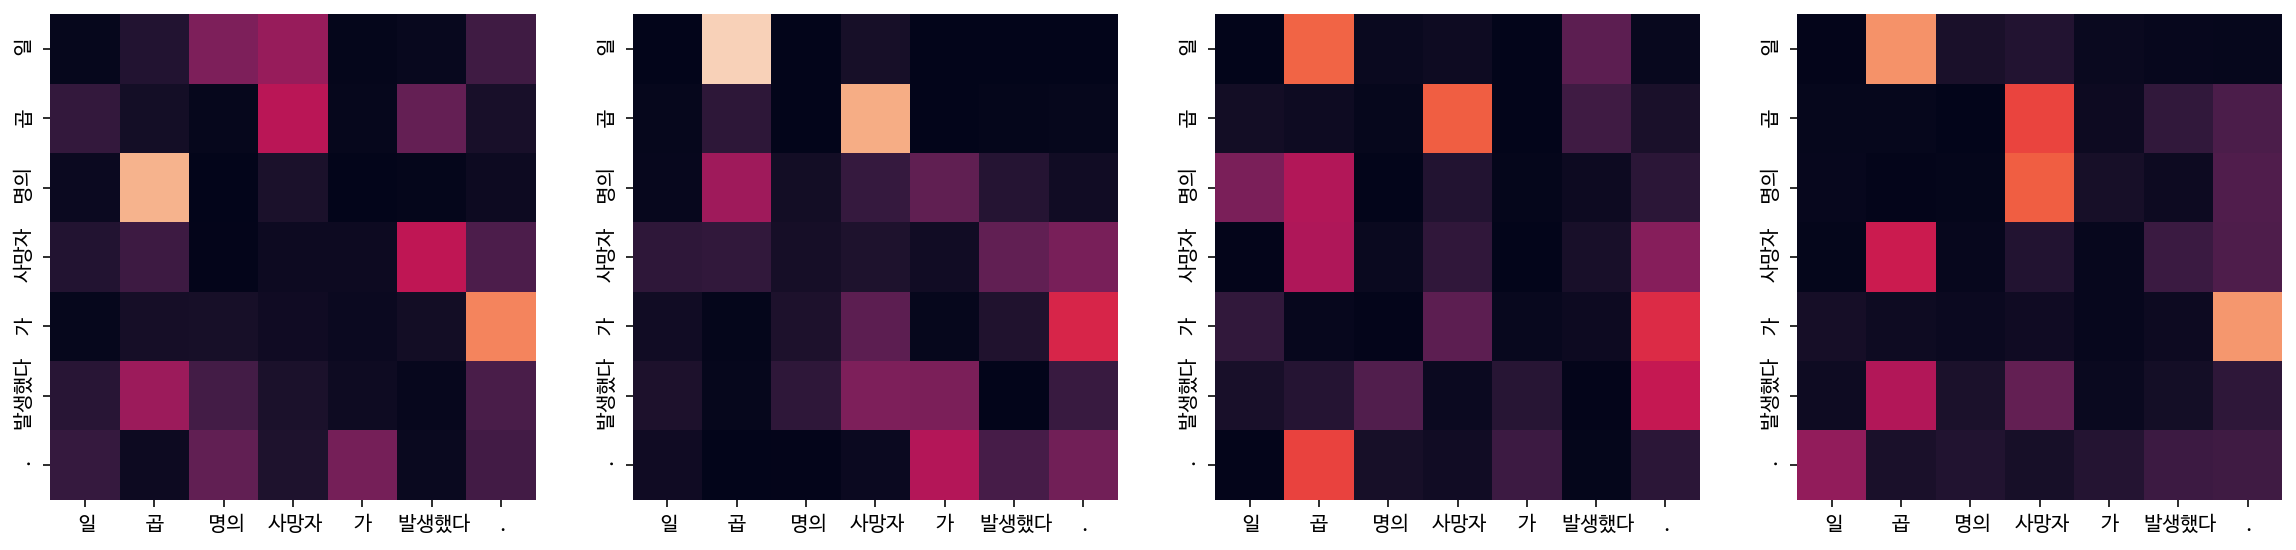

Encoder Layer 2


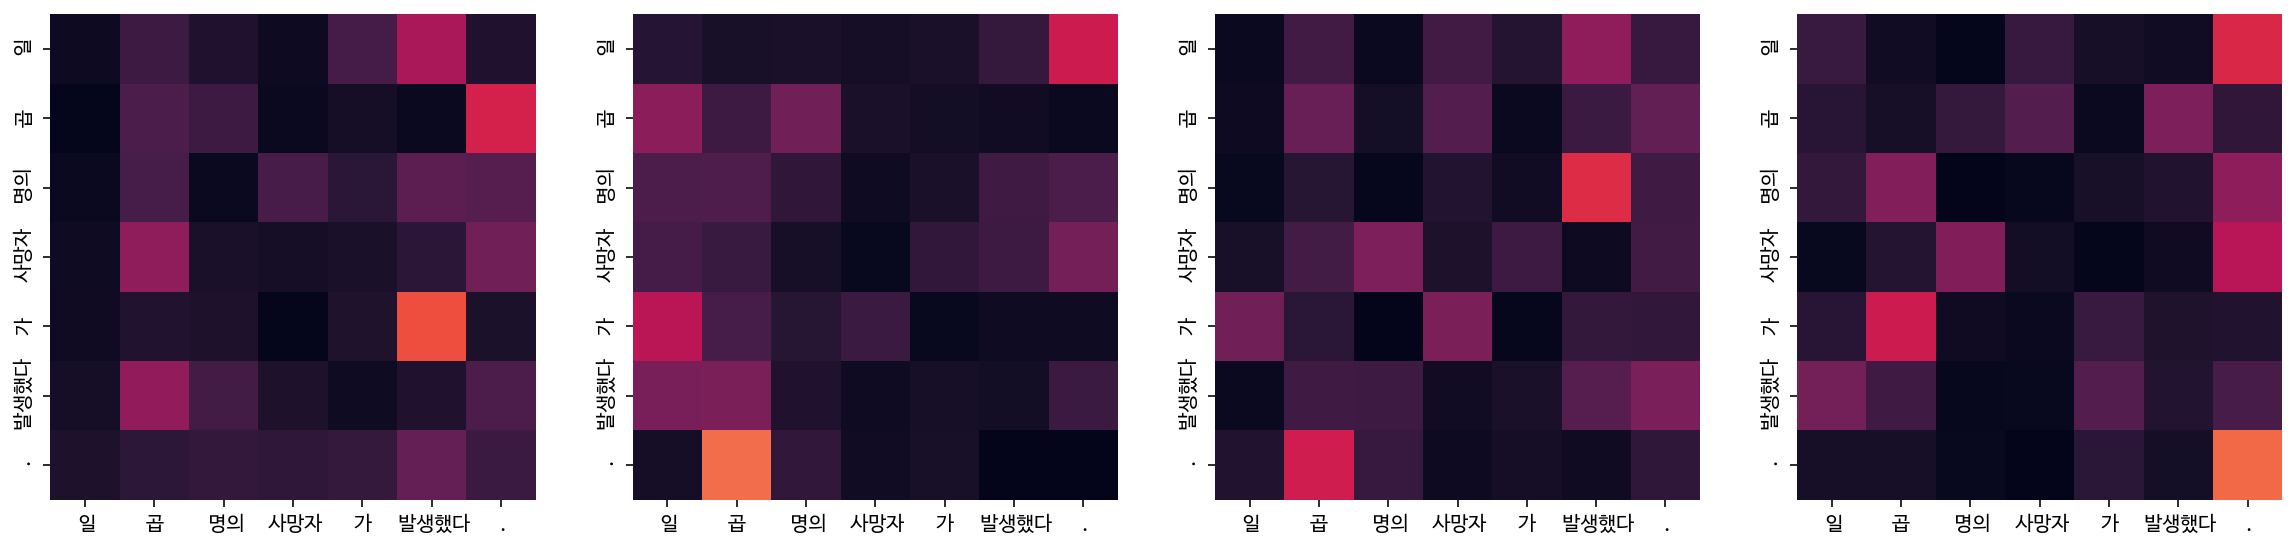

Decoder Self Layer 1


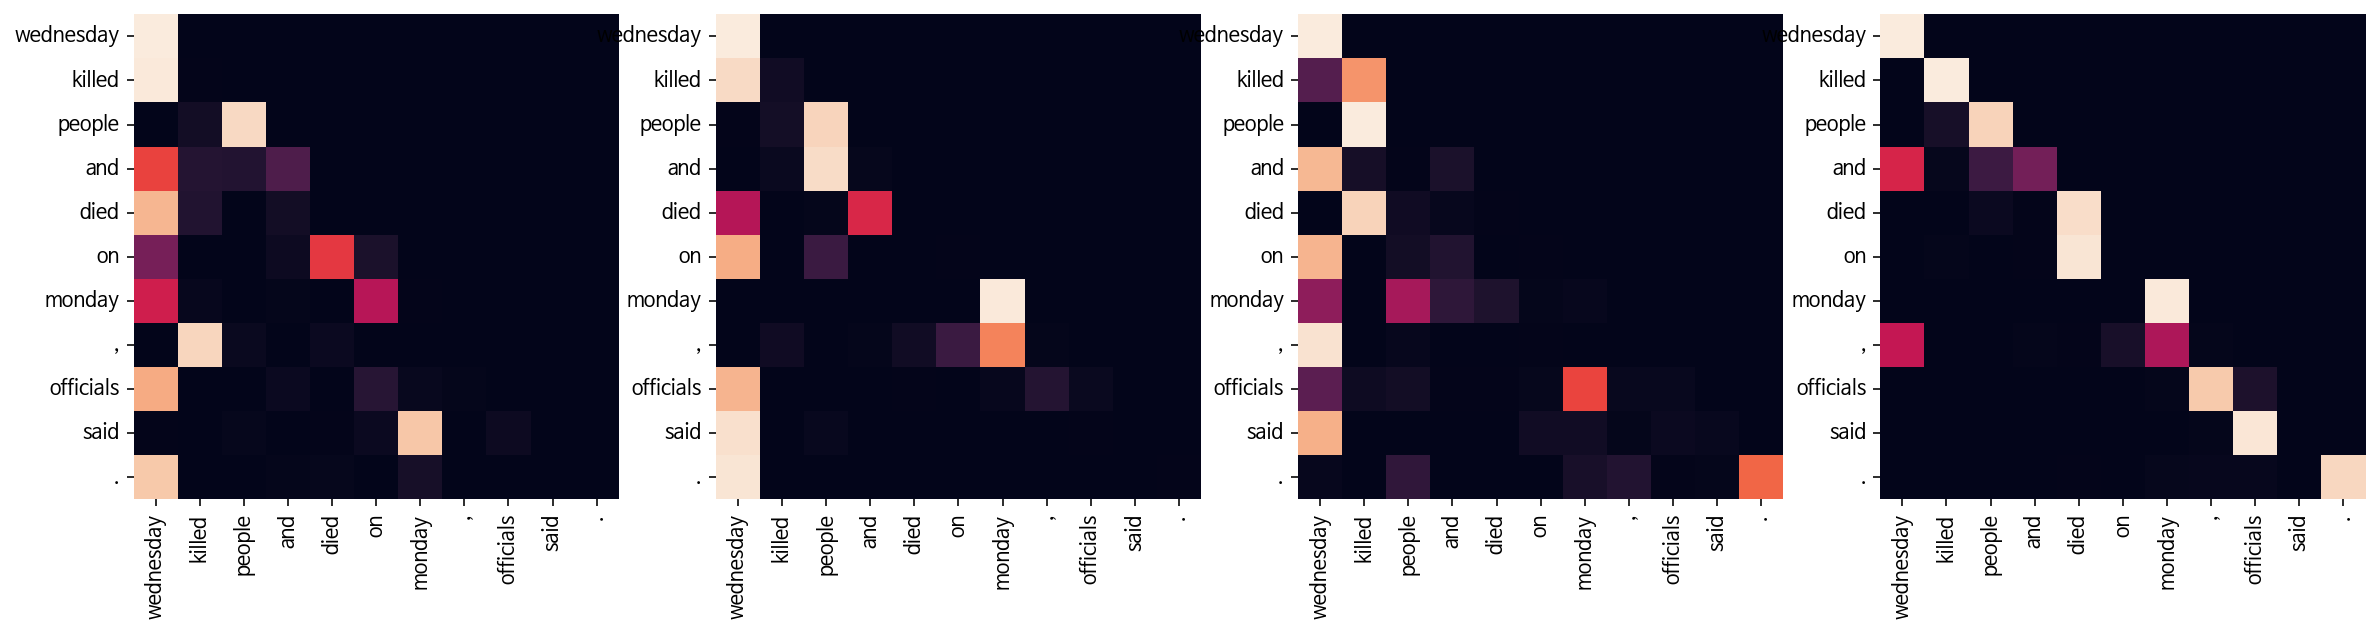

Decoder Src Layer 1


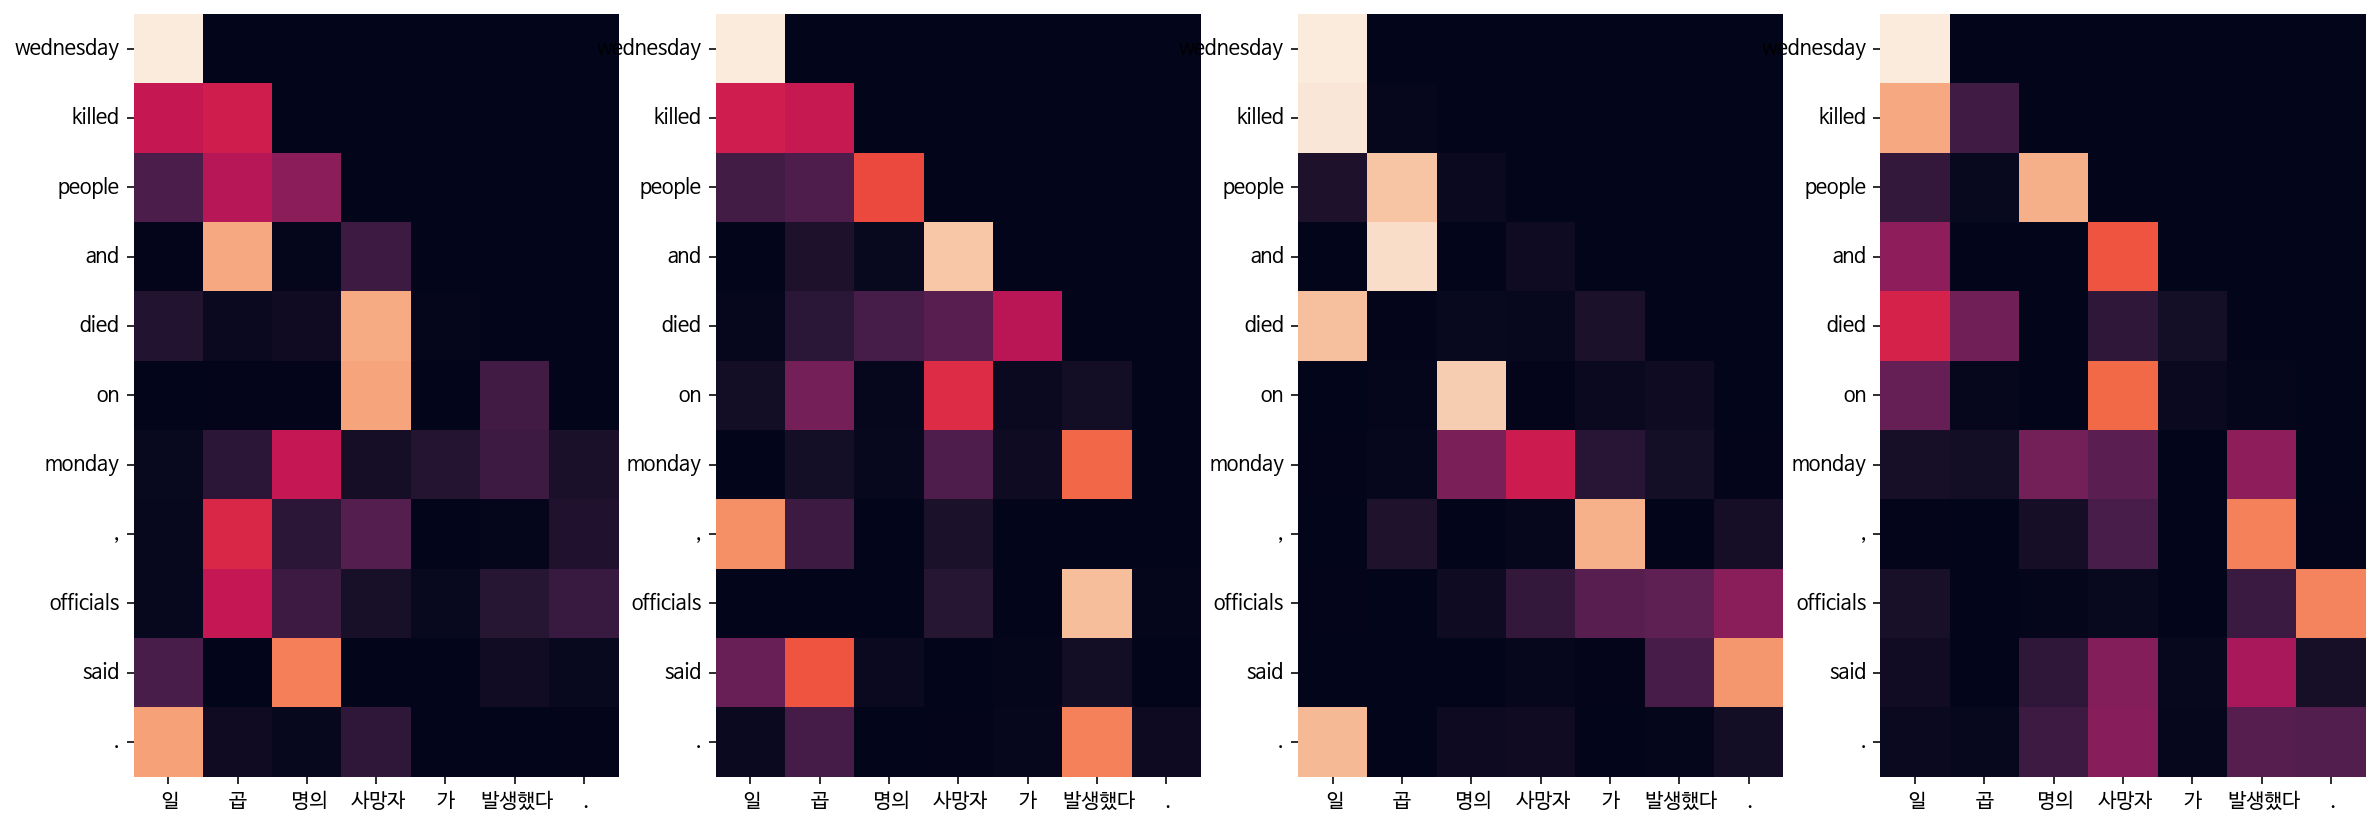

Decoder Self Layer 2


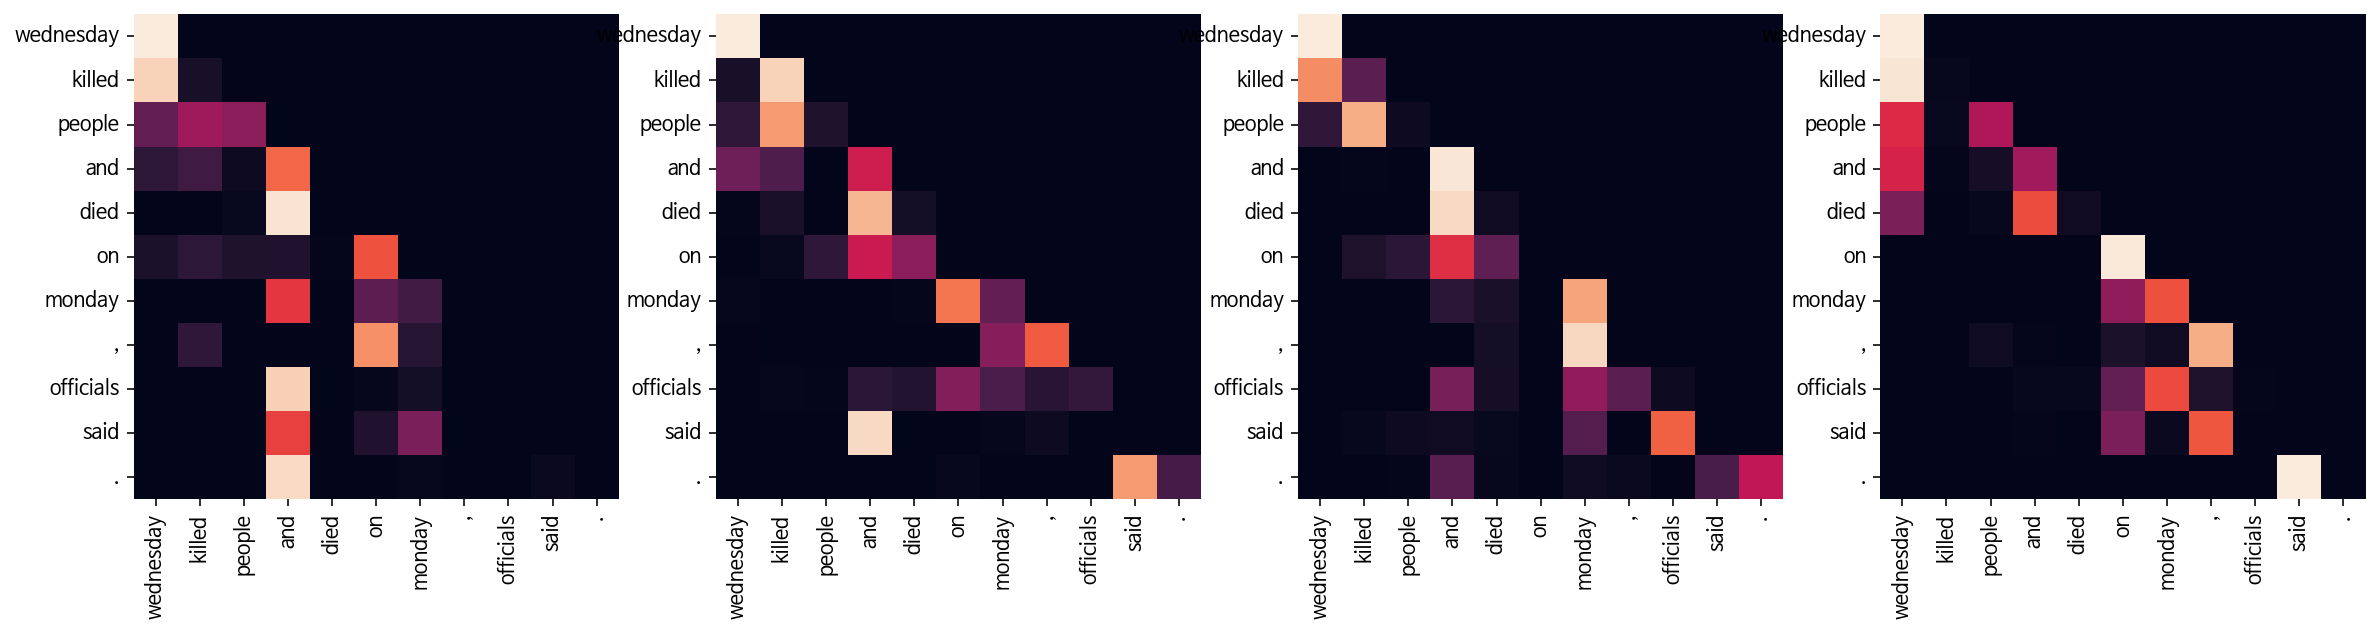

Decoder Src Layer 2


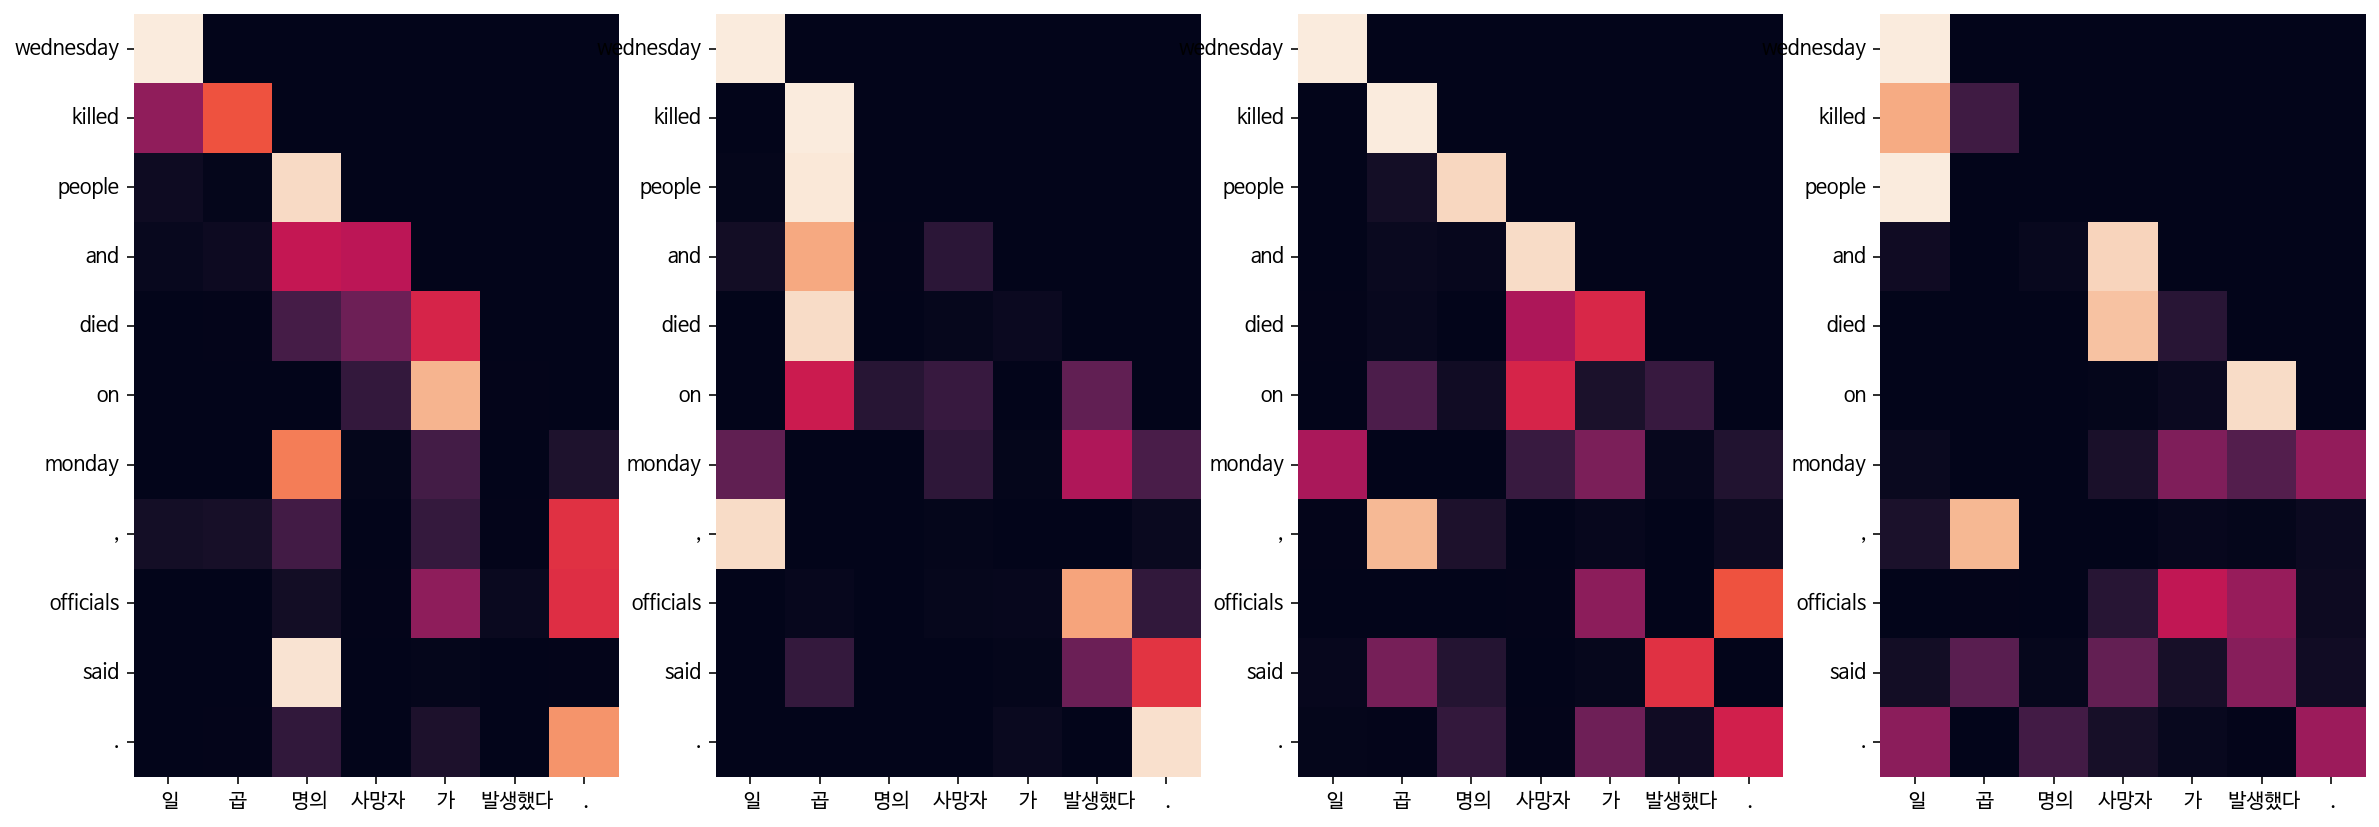

In [33]:
for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer, plot_attention=True)

## 회고
- Transformer와 더 친해지고 싶다.
- 더 높은 성능을 얻기 위해서 무엇을 어떻게 바꿔봐야할지 고민해봐야겠다.
- seq2seq보다는 확실히 결과가 더 나은 것 같아서 그나마 다행이다.
- NLP는 어렵지만, 포기하지 않을거다! 